In [1]:
# enabling 3rd party widgets
# from google.colab import output
# output.enable_custom_widget_manager()
# output.disable_custom_widget_manager()

# interactive 3D plot
# !pip install ipympl
# %matplotlib widget

In [2]:
import os
import sys
import math
from collections import OrderedDict
import numpy as np
import matplotlib.pyplot as plt
from scipy import linalg

import time as time
import platform as platform

import tensorflow as tf
from tensorflow.keras import layers, losses
from tensorflow.keras.models import Model
from tensorflow.keras import backend as K
from tensorflow.keras.regularizers import L2
import h5py

from skopt import gp_minimize
from skopt.space import Integer, Real

tf.keras.backend.set_floatx('float32')

plt.rcParams.update({
    "text.usetex":True,
    "font.family":"serif"
})

In [3]:
colab_flag = False
FTYPE = np.float32
ITYPE = np.int32

array = np.array
float32 = np.float32
int32 = np.int32
float64 = np.float64
int64 = np.int64

strategy = None
# strategy = tf.distribute.MirroredStrategy()

In [4]:
current_sys = platform.system()

if current_sys == 'Windows':
    dir_sep = '\\'
else:
    dir_sep = '/'

In [5]:
if colab_flag == True:
    from google.colab import drive
    drive.mount('/content/drive')
    os.chdir('/content/drive/MyDrive/Github/MLROM/KS/')

In [6]:
print(os.getcwd())

/home/rkaushik/Documents/Thesis/MLROM/new_ks


In [7]:
from tools.misc_tools import create_data_for_RNN, mytimecallback, SaveLosses, plot_losses
from tools.ae_v1 import Autoencoder
from tools.ESN_v1 import ESN
from tools.hyper_param_ESN import trainESN_and_return_PH

In [8]:
behaviour = 'initialiseAndTrainFromScratch'
# behaviour = 'loadCheckpointAndContinueTraining'
# behaviour = 'loadFinalNetAndPlot'

In [9]:
# setting seed for PRNGs
if behaviour == 'initialiseAndTrainFromScratch':
    prng_seed = 42
    np.random.seed(prng_seed)
    tf.random.set_seed(prng_seed)

In [10]:
gpus = tf.config.list_physical_devices('GPU')
print(gpus)

if colab_flag == False:
    if strategy is None:
        if gpus:
            gpu_to_use = 0
            tf.config.set_visible_devices(gpus[gpu_to_use], 'GPU')
    logical_devices = tf.config.list_logical_devices('GPU')
    print(logical_devices)

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU'), PhysicalDevice(name='/physical_device:GPU:1', device_type='GPU')]
[LogicalDevice(name='/device:GPU:0', device_type='GPU')]


2023-06-20 04:36:56.045239: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-06-20 04:36:56.045491: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-06-20 04:36:56.086452: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-06-20 04:36:56.086758: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-06-20 04:36:56.086966: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from S

In [11]:
# print(tf.test.gpu_device_name())
print(tf.config.list_physical_devices())
print(tf.config.list_logical_devices())
print(tf.__version__)

[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'), PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU'), PhysicalDevice(name='/physical_device:GPU:1', device_type='GPU')]
[LogicalDevice(name='/device:CPU:0', device_type='CPU'), LogicalDevice(name='/device:GPU:0', device_type='GPU')]
2.8.1


# KS System

In [12]:
# setting up params (and saving, if applicable)
# from numpy import *

# making RNN save directory
dir_name_rnn = os.getcwd() + dir_sep + 'ESN_params_Search'
if not os.path.isdir(dir_name_rnn):
    os.makedirs(dir_name_rnn)

counter = 0
while True:
    dir_check = 'params_search_' + str(counter).zfill(3)
    if os.path.isdir(dir_name_rnn + dir_sep + dir_check):
        counter += 1
    else:
        break

dir_name_rnn = dir_name_rnn + dir_sep + dir_check
os.makedirs(dir_name_rnn)
dir_name_rnn_plots = dir_name_rnn+dir_sep+'plots'
os.makedirs(dir_name_rnn_plots)

# whether to use AE data or just work on raw data
use_ae_data = True # if false, specifying ae_idx will only show which dataset to use

# autoencoder directory
# ae_idx = '046'
# dir_name_ae = os.getcwd()+'{ds}saved_ae{ds}ae_'.format(ds=dir_sep)+ae_idx
dir_name_ae = os.getcwd()+'{ds}saved_ae{ds}ae_000'.format(ds=dir_sep)

# reading simulation parameters
with open(dir_name_ae + dir_sep + 'ae_data.txt') as f:
    lines = f.readlines()
params_dict = eval(''.join(lines))
data_dir_idx = params_dict['data_dir_idx']
normalizeforae_flag = params_dict['normalizeforae_flag']
normalization_constant_arr_aedata = params_dict['normalization_constant_arr_aedata']
try:
    ae_data_with_params = params_dict['ae_data_with_params']
except:
    print("'ae_data_with_params' not present in ae_data, set to 'True'.")
    ae_data_with_params = True

if os.path.exists(dir_name_ae+dir_sep+'normalization_data.npz'):
    with np.load(dir_name_ae+dir_sep+'normalization_data.npz', allow_pickle=True) as fl:
        normalization_constant_arr_aedata = fl['normalization_constant_arr_aedata'][0]

print('dir_name_rnn:', dir_name_rnn)
print('use_ae_data : ' + str(use_ae_data) + ', dir_name_ae:', dir_name_ae)
print('data_dir_idx:', data_dir_idx)

# loading data
dir_name_data = os.getcwd() + dir_sep + 'saved_data' + dir_sep + 'data_' + data_dir_idx
    
with open(dir_name_data + dir_sep + 'sim_data_params.txt') as f:
    lines = f.readlines()
params_dict = eval(''.join(lines))
params_mat = params_dict['params_mat']
# init_state = params_dict['init_state']
t0 = params_dict['t0']
T = params_dict['T']
delta_t = params_dict['delta_t']
return_params_arr = params_dict['return_params_arr']
normalize_flag_ogdata = params_dict['normalize_flag']
print('normalize_flag_ogdata:', normalize_flag_ogdata)
alldata_withparams_flag = params_dict['alldata_withparams_flag']

with np.load(dir_name_data+dir_sep+'data.npz', allow_pickle=True) as fl:
    all_data = fl['all_data'].astype(FTYPE)
    boundary_idx_arr = fl['boundary_idx_arr']
    normalization_constant_arr_ogdata = fl['normalization_constant_arr'][0]
    initial_t0 = fl['initial_t0']
    init_state_mat = fl['init_state_mat']

    lyapunov_spectrum_mat = fl['lyapunov_spectrum_mat']

dir_name_rnn: /home/rkaushik/Documents/Thesis/MLROM/new_ks/ESN_params_Search/params_search_000
use_ae_data : True, dir_name_ae: /home/rkaushik/Documents/Thesis/MLROM/new_ks/saved_ae/ae_000
data_dir_idx: 000
normalize_flag_ogdata: False


In [13]:
lyapunov_time_arr = np.empty(shape=lyapunov_spectrum_mat.shape[0], dtype=FTYPE)
for i in range(lyapunov_spectrum_mat.shape[0]):
    lyapunov_time_arr[i] = 1/lyapunov_spectrum_mat[i, 0]
    print('Case : {}, lyapunov exponent : {}, lyapunov time : {}s'.format(i+1, lyapunov_spectrum_mat[i, 0], lyapunov_time_arr[i]))

Case : 1, lyapunov exponent : 0.06465670311438651, lyapunov time : 15.466300964355469s


In [14]:
positve_lp_idx = np.where(lyapunov_time_arr > 0)[0]
print(positve_lp_idx)

[0]


In [15]:
last_idx = all_data.shape[0]
temp_bia = np.zeros(shape=1+boundary_idx_arr.shape[0], dtype=np.int32)
temp_bia[1:] = boundary_idx_arr
print(temp_bia)
for i in range(boundary_idx_arr.shape[0]-1, -1, -1):
    if not (i in positve_lp_idx):
        print(i)
        num_idxs = last_idx - temp_bia[i+1]
        all_data[temp_bia[i]:temp_bia[i]+num_idxs] = all_data[temp_bia[i+1]:last_idx]
        last_idx = last_idx - (temp_bia[i+1]-temp_bia[i])

[     0 500026]


In [16]:
new_bia = np.empty_like(boundary_idx_arr)
new_bia[:] = boundary_idx_arr
new_pmat = np.empty_like(params_mat)
new_pmat[:, :] = params_mat
counter = 0
bia_counter = boundary_idx_arr.shape[0]
for i in range(boundary_idx_arr.shape[0]):
    if not (i in positve_lp_idx):
        new_bia[i:] -= temp_bia[i+1] - temp_bia[i]
        new_bia[i:bia_counter-1] = new_bia[i+1:bia_counter]
        new_pmat[i:bia_counter-1] = new_pmat[i+1:bia_counter]
        bia_counter -= 1

In [17]:
new_bia = new_bia[0:bia_counter]
new_pmat = new_pmat[0:bia_counter]

In [18]:
all_data = all_data[0:new_bia[-1]]

In [19]:
new_bia, boundary_idx_arr = boundary_idx_arr, new_bia
new_pmat, params_mat = params_mat, new_pmat

In [20]:
# delaing with normalizing the data before feeding into autoencoder
num_params = params_mat.shape[1]
og_vars = all_data.shape[1]
if alldata_withparams_flag == True:
    og_vars -= num_params

if use_ae_data == True:
    if ae_data_with_params == True and alldata_withparams_flag == False:
        new_all_data = np.empty(shape=(all_data.shape[0], og_vars+num_params), dtype=FTYPE)
        new_all_data[:, 0:og_vars] = all_data[:, 0:og_vars]
        del(all_data)
        all_data = new_all_data
        prev_idx = 0
        for i in range(boundary_idx_arr.shape[0]):
            all_data[prev_idx:boundary_idx_arr[i], num_params:] = params_mat[i]
            prev_idx = boundary_idx_arr[i]

    if normalizeforae_flag == True:
        for i in range(all_data.shape[1]):
            all_data[:, i] -= normalization_constant_arr_aedata[0, i]
            all_data[:, i] /= normalization_constant_arr_aedata[1, i]

    if ae_data_with_params == False:
        all_data = all_data[:, 0:og_vars]
else:
    # using raw data, neglecting the params attached (if any)
    all_data = all_data[:, 0:og_vars]

# Autoencoder

In [21]:
if use_ae_data == True:
    load_file = dir_name_ae+dir_sep+'final_net'+dir_sep+'final_net_class_dict.txt'
    wt_file = dir_name_ae+dir_sep+'final_net'+dir_sep+'final_net_ae_weights.h5'

In [22]:
if use_ae_data == True:
    ae_net = Autoencoder(all_data.shape[1], load_file=load_file)
    ae_net.load_weights_from_file(wt_file)

In [23]:
# create data
if use_ae_data == True:
    latent_states_all = ae_net.encoder_net.predict(all_data)
    del(all_data)
else:
    latent_states_all = all_data
num_latent_states = latent_states_all.shape[1]

# ESN

In [24]:
# RNN data parameters
dt_rnn = 0.1
num_input_tsteps = 25000
T_sample_input = num_input_tsteps*dt_rnn
T_sample_output = T_sample_input
T_offset = dt_rnn
normalize_dataset = True # whether the data for the RNN should be normalized by the dataset's mean and std
normalization_arr = None
stddev_multiplier = 3
skip_intermediate = 'full sample'
noise_type = 'normal' # can be 'uniform' or 'normal'
normalization_type = 'stddev' # can be 'minmax' or 'stddev', if it is
                              # 'minmax' then stddev_multiplier has no effect
ESN_layers_units = [num_latent_states*200]
stateful = True
omega_in_x0 = 1.0
degree_of_connectivity_x0 = 3
rho_res_x0 = 0.8
usebias_Win = [False]
alpha_x0 = 0.99
ESN_cell_activations = ['tanh']
usebias_Wout = True

activation_post_Wout = 'linear'
use_weights_post_dense = False

vary_deg_connect = False # whether to search for degree_of_connectivity or use it as a constant

if return_params_arr != False:
    params = params_arr
else:
    params = None

# saving simulation data
sim_data = {
    'params_mat':params_mat,
    'init_state_mat':init_state_mat,
    't0':t0,
    'T':T,
    'delta_t':delta_t,
    'return_params_arr':return_params_arr,
    'dir_name_ae':dir_name_ae,
    'normalize_dataset':normalize_dataset,
    'stddev_multiplier':stddev_multiplier,
    'use_ae_data':use_ae_data,
    'vary_deg_connect':vary_deg_connect,
}

# saving RNN specific data
RNN_specific_data = {
    'dt_rnn':dt_rnn,
    'T_sample_input':T_sample_input,
    'T_sample_output':T_sample_output,
    'T_offset':T_offset,
    'boundary_idx_arr':boundary_idx_arr,
    'delta_t':delta_t,
    'params':params,
    'return_params_arr':return_params_arr,
    'normalize_dataset':normalize_dataset,
    'num_input_tsteps':num_input_tsteps,
    'stddev_multiplier':stddev_multiplier,
    'skip_intermediate':skip_intermediate,
    'module':ESN.__module__,
    'noise_type':noise_type,
    'normalization_type':normalization_type,
}

In [25]:
latent_states_all = latent_states_all[0:375009]
boundary_idx_arr = [375009]

In [26]:
rnn_res_dict = create_data_for_RNN(
    latent_states_all,
    dt_rnn,
    T_sample_input,
    T_sample_output,
    T_offset,
    None,
    boundary_idx_arr,
    delta_t,
    params=params,
    return_numsamples=True,
    normalize_dataset=normalize_dataset,
    stddev_multiplier=stddev_multiplier,
    skip_intermediate=skip_intermediate,
    return_OrgDataIdxArr=False,
    normalization_arr_external=normalization_arr,
    normalization_type=normalization_type,
    FTYPE=FTYPE,
    ITYPE=ITYPE)
    
data_rnn_input = rnn_res_dict['data_rnn_input']
data_rnn_output = rnn_res_dict['data_rnn_output']
org_data_idx_arr_input = rnn_res_dict['org_data_idx_arr_input']
org_data_idx_arr_output = rnn_res_dict['org_data_idx_arr_output']
num_samples = rnn_res_dict['num_samples']
normalization_arr = rnn_res_dict['normalization_arr']
rnn_data_boundary_idx_arr = rnn_res_dict['rnn_data_boundary_idx_arr']

In [27]:
temp = np.divide(latent_states_all-normalization_arr[0], normalization_arr[1])
time_stddev = np.std(temp, axis=0)
timeMeanofSpaceRMS = np.mean(np.mean(temp**2, axis=1)**0.5)
del(org_data_idx_arr_input)
del(org_data_idx_arr_output)
del(latent_states_all)
del(temp)

In [28]:
# setting up training params
num_ensemble_mems = 5
epochs = 1
lambda_reg_x0 = 1e-7 # weight for regularizer
min_delta = 1e-6
patience = 5
train_split = 0.8
val_split = 0.1
test_split = 1 - train_split - val_split
batch_size = 1
fRMS_x0 = 1e-3
use_best = False

# ph computation parameters
num_runs = 25
T_sample_input_AR_ratio = 1
T_sample_output_AR_ratio = 5

# saving training params
training_specific_params = {
    'epochs':epochs,
    'prng_seed':prng_seed,
    'train_split':train_split,
    'val_split':val_split,
    'batch_size':batch_size,
    # 'fRMS':fRMS,
    'timeMeanofSpaceRMS':timeMeanofSpaceRMS,
    # 'stddev':stddev,
    # 'lambda_reg':lambda_reg,
    'min_delta':min_delta,
    'patience':patience,
    'use_best':use_best,
    'degree_of_connectivity_x0':degree_of_connectivity_x0,
}

In [29]:
cum_samples = rnn_data_boundary_idx_arr[-1]
# idx = np.arange(cum_samples)
# np.random.shuffle(idx)
num_train = 0
num_val = 0
begin_idx = 0
for i in range(len(boundary_idx_arr)):
    num_samples = rnn_data_boundary_idx_arr[i] - begin_idx
    num_train += int( np.round(train_split*num_samples) )
    num_val += int( np.round(val_split*num_samples) )
    begin_idx = rnn_data_boundary_idx_arr[i]

# defining shapes
training_input_shape = [num_train]
training_input_shape.extend(data_rnn_input.shape[1:])

training_output_shape = [num_train]
training_output_shape.extend(data_rnn_output.shape[1:])

val_input_shape = [num_val]
val_input_shape.extend(data_rnn_input.shape[1:])

val_output_shape = [num_train]
val_output_shape.extend(data_rnn_output.shape[1:])

testing_input_shape = [cum_samples-num_train-num_val]
testing_input_shape.extend(data_rnn_input.shape[1:])

testing_output_shape = [cum_samples-num_train-num_val]
testing_output_shape.extend(data_rnn_output.shape[1:])

# defining required arrays
training_data_rnn_input = np.empty(shape=training_input_shape, dtype=FTYPE)
training_data_rnn_output = np.empty(shape=training_output_shape, dtype=FTYPE)

val_data_rnn_input = np.empty(shape=val_input_shape, dtype=FTYPE)
val_data_rnn_output = np.empty(shape=val_output_shape, dtype=FTYPE)

testing_data_rnn_input = np.empty(shape=testing_input_shape, dtype=FTYPE)
testing_data_rnn_output = np.empty(shape=testing_output_shape, dtype=FTYPE)

begin_idx = 0
training_data_rolling_count = 0
val_data_rolling_count = 0
testing_data_rolling_count = 0
for i in range(len(boundary_idx_arr)):
    idx = np.arange(begin_idx, rnn_data_boundary_idx_arr[i])
    # np.random.shuffle(idx)
    num_samples = idx.shape[0]
    num_train = int( np.round(train_split*num_samples) )
    num_val = int( np.round(val_split*num_samples) )

    training_data_rnn_input[training_data_rolling_count:training_data_rolling_count+num_train] = data_rnn_input[idx[0:num_train]]
    training_data_rnn_output[training_data_rolling_count:training_data_rolling_count+num_train] = data_rnn_output[idx[0:num_train]]
    training_data_rolling_count += num_train

    val_data_rnn_input[val_data_rolling_count:val_data_rolling_count+num_val] = data_rnn_input[idx[num_train:num_train+num_val]]
    val_data_rnn_output[val_data_rolling_count:val_data_rolling_count+num_val] = data_rnn_output[idx[num_train:num_train+num_val]]
    val_data_rolling_count += num_val

    num_test = num_samples-num_train-num_val+1
    testing_data_rnn_input[testing_data_rolling_count:testing_data_rolling_count+num_test] = data_rnn_input[idx[num_train+num_val:]]
    testing_data_rnn_output[testing_data_rolling_count:testing_data_rolling_count+num_test] = data_rnn_output[idx[num_train+num_val:]]
    testing_data_rolling_count += num_test

    begin_idx = rnn_data_boundary_idx_arr[i]

# cleaning up
del(data_rnn_input)
del(data_rnn_output)

# further shuffling
# idx = np.arange(0, training_data_rnn_input.shape[0])
# np.random.shuffle(idx)
# training_data_rnn_input = training_data_rnn_input[idx]
# training_data_rnn_output = training_data_rnn_output[idx]

# idx = np.arange(0, val_data_rnn_input.shape[0])
# np.random.shuffle(idx)
# val_data_rnn_input = val_data_rnn_input[idx]
# val_data_rnn_output = val_data_rnn_output[idx]

# idx = np.arange(0, testing_data_rnn_input.shape[0])
# np.random.shuffle(idx)
# testing_data_rnn_input = testing_data_rnn_input[idx]
# testing_data_rnn_output = testing_data_rnn_output[idx]

# del(idx)

In [30]:
print('training_data_rnn_input.shape : ', training_data_rnn_input.shape)
print(' testing_data_rnn_input.shape : ', testing_data_rnn_input.shape)
print('     val_data_rnn_input.shape : ', val_data_rnn_input.shape)

training_data_rnn_input.shape :  (11, 25000, 16)
 testing_data_rnn_input.shape :  (2, 25000, 16)
     val_data_rnn_input.shape :  (1, 25000, 16)


In [31]:
val_loss_hist = []
train_loss_hist = []

In [32]:
training_data_rnn_input.dtype

dtype('float32')

In [33]:
def optim_func(
        x, # [fRMS, lambda_reg, rho_res, omega_in, alpha, degree_of_connectivity]
        time_stddev=time_stddev,
        og_vars=og_vars,
        ESN=ESN,
        plot_losses=plot_losses,
        dir_name_rnn=dir_name_rnn,
        boundary_idx_arr=boundary_idx_arr,
        lyapunov_time_arr=lyapunov_time_arr,
        sim_data_dict=sim_data,
        RNN_specific_data_dict=RNN_specific_data,
        training_specific_params_dict=training_specific_params,
        normalization_arr=normalization_arr,
        training_data_rnn_input=training_data_rnn_input,
        training_data_rnn_output=training_data_rnn_output,
        testing_data_rnn_input=testing_data_rnn_input,
        testing_data_rnn_output=testing_data_rnn_output,
        val_data_rnn_input=val_data_rnn_input,
        val_data_rnn_output=val_data_rnn_output,
        return_params_arr=return_params_arr,
        normalize_dataset=normalize_dataset,
        dt_rnn=dt_rnn,
        noise_type=noise_type,
        num_ensemble_mems=num_ensemble_mems,
        ESN_layers_units=ESN_layers_units,
        stateful=stateful,
        usebias_Win=usebias_Win,
        ESN_cell_activations=ESN_cell_activations,
        usebias_Wout=usebias_Wout,
        activation_post_Wout=activation_post_Wout,
        use_weights_post_dense=use_weights_post_dense,
        prng_seed=prng_seed,
        epochs=epochs,
        patience=patience,  # parameter for early stopping
        min_delta=min_delta,  # parameter for early stopping
        batch_size=batch_size,
        num_runs=num_runs,
        T_sample_input_AR_ratio=T_sample_input_AR_ratio,
        T_sample_output_AR_ratio=T_sample_output_AR_ratio,
        use_best=use_best,
        deg_of_connectivity=degree_of_connectivity_x0,
    ):
    
    compute_time = time.time()
    
    x_in = x
    if len(x) == 5:
        x_in = [elem for elem in x]
        x_in.append(deg_of_connectivity)

    median_PH = trainESN_and_return_PH(
        x_in, # [fRMS, lambda_reg, rho_res, omega_in, alpha, degree_of_connectivity]
        time_stddev,
        og_vars,
        ESN,
        plot_losses,
        dir_name_rnn,
        boundary_idx_arr,
        lyapunov_time_arr,
        sim_data_dict,
        RNN_specific_data_dict,
        training_specific_params_dict,
        normalization_arr,
        training_data_rnn_input,
        training_data_rnn_output,
        testing_data_rnn_input,
        testing_data_rnn_output,
        val_data_rnn_input,
        val_data_rnn_output,
        return_params_arr,
        normalize_dataset,
        dt_rnn,
        noise_type,
        num_ensemble_mems=num_ensemble_mems,
        ESN_layers_units=ESN_layers_units,
        stateful=stateful,
        usebias_Win=usebias_Win,
        ESN_cell_activations=ESN_cell_activations,
        usebias_Wout=usebias_Wout,
        activation_post_Wout=activation_post_Wout,
        use_weights_post_dense=use_weights_post_dense,
        prng_seed=prng_seed,
        epochs=epochs,
        patience=patience,  # parameter for early stopping
        min_delta=min_delta,  # parameter for early stopping
        batch_size=batch_size,
        num_runs=num_runs,
        T_sample_input_AR_ratio=T_sample_input_AR_ratio,
        T_sample_output_AR_ratio=T_sample_output_AR_ratio,
        use_best=use_best,
    )
    
    compute_time = time.time() - compute_time
    print('compute_time : {:.0f}h {:.0f}m {:.0f}s'.format(
        float(compute_time // 3600),
        float((compute_time%3600)//60),
        float((compute_time%3600)%60),
    ))
    
    return -median_PH

In [34]:
fRMS_bounds = Real(0.1/100, 10/100, "log-uniform")
lambda_reg_bounds = Real(1e-7, 1e-3, "log-uniform")
rho_res_bounds = Real(0.2, 0.95)
omega_in_bounds = Real(0.5, 1.5)
alpha_bounds = Real(0.5, 1.0)
degree_of_connectivity_bounds = Integer(1, 10)
acq_func = "EI"
n_initial_points = 10
n_calls = n_initial_points + 50

optim_dict = {
    'fRMS_bounds':fRMS_bounds,
    'lambda_reg_bounds':lambda_reg_bounds,
    'rho_res_bounds':rho_res_bounds,
    'omega_in_bounds':omega_in_bounds,
    'alpha_bounds':alpha_bounds,
    # 'degree_of_connectivity_bounds':degree_of_connectivity_bounds,
    'n_calls':n_calls,
    'acq_func':acq_func,
    'n_initial_points':n_initial_points,
    'random_state':prng_seed,
}
if vary_deg_connect == True:
    optim_dict['degree_of_connectivity_bounds'] = degree_of_connectivity_bounds
with open(dir_name_rnn + '/optim_params.txt', 'w') as f:
    f.write(str(optim_dict))
    
dimensions = [
    fRMS_bounds,
    lambda_reg_bounds,
    rho_res_bounds,
    omega_in_bounds,
    alpha_bounds,
    # degree_of_connectivity_bounds
]
if vary_deg_connect == True:
    dimensions.append(degree_of_connectivity_bounds)

In [35]:
x0 = [fRMS_x0, lambda_reg_x0, rho_res_x0, omega_in_x0, alpha_x0]
if vary_deg_connect == True:
    x0.append(degree_of_connectivity_x0)

res = gp_minimize(
    optim_func,
    dimensions,
    x0=x0,
    n_calls=n_calls,
    n_initial_points=n_initial_points,
    random_state=prng_seed,
    acq_func=acq_func,
)

--- ENSEMBLE MEMBER 1/5 ---


--------------------------------------------------------------------------------

---------------------------------- EPOCH : 1 -----------------------------------

--------------------------------------------------------------------------------


1 / 11 -- Wout batch_time : 6.67 s -- eta : 0h 1m 7s
2 / 11 -- Wout batch_time : 6.57 s -- eta : 0h 0m 60s
3 / 11 -- Wout batch_time : 6.58 s -- eta : 0h 0m 53s
4 / 11 -- Wout batch_time : 6.61 s -- eta : 0h 0m 46s
5 / 11 -- Wout batch_time : 6.55 s -- eta : 0h 0m 40s
6 / 11 -- Wout batch_time : 6.86 s -- eta : 0h 0m 33s
7 / 11 -- Wout batch_time : 6.82 s -- eta : 0h 0m 27s
8 / 11 -- Wout batch_time : 7.13 s -- eta : 0h 0m 20s
9 / 11 -- Wout batch_time : 6.74 s -- eta : 0h 0m 13s
10 / 11 -- Wout batch_time : 6.62 s -- eta : 0h 0m 7s
11 / 11 -- Wout batch_time : 6.90 s -- eta : 0h 0m 0s

epoch_time : 76.06798505783081 sec

val mse
1 / 1 -- batch_time : 3.1729705333709717 sec

training mse
1 / 11 -- batch_time : 3.2

2 / 2
test_mse : 4.0606664697406814e-07
tested_ESN/test_ESN_000
num_runs : 25
    build_time : 0h 0m 11s
    1 / 25 -- run_time : 5.32 s -- eta : 0h 2m 8s
    2 / 25 -- run_time : 4.38 s -- eta : 0h 1m 52s
    3 / 25 -- run_time : 4.60 s -- eta : 0h 1m 45s
    4 / 25 -- run_time : 4.87 s -- eta : 0h 1m 41s
    5 / 25 -- run_time : 4.45 s -- eta : 0h 1m 35s
    6 / 25 -- run_time : 4.53 s -- eta : 0h 1m 29s
    7 / 25 -- run_time : 4.47 s -- eta : 0h 1m 24s
    8 / 25 -- run_time : 4.90 s -- eta : 0h 1m 20s
    9 / 25 -- run_time : 4.92 s -- eta : 0h 1m 15s
    10 / 25 -- run_time : 4.30 s -- eta : 0h 1m 10s
    11 / 25 -- run_time : 4.49 s -- eta : 0h 1m 5s
    12 / 25 -- run_time : 4.63 s -- eta : 0h 1m 1s
    13 / 25 -- run_time : 4.35 s -- eta : 0h 0m 56s
    14 / 25 -- run_time : 4.66 s -- eta : 0h 0m 51s
    15 / 25 -- run_time : 4.41 s -- eta : 0h 0m 46s
    16 / 25 -- run_time : 4.67 s -- eta : 0h 0m 42s
    17 / 25 -- run_time : 4.46 s -- eta : 0h 0m 37s
    18 / 25 -- run_time

2 / 2
test_mse : 1.6017760572140105e-05
--- ENSEMBLE MEMBER 5/5 ---


--------------------------------------------------------------------------------

---------------------------------- EPOCH : 1 -----------------------------------

--------------------------------------------------------------------------------


1 / 11 -- Wout batch_time : 7.23 s -- eta : 0h 1m 12s
2 / 11 -- Wout batch_time : 6.70 s -- eta : 0h 1m 3s
3 / 11 -- Wout batch_time : 6.90 s -- eta : 0h 0m 56s
4 / 11 -- Wout batch_time : 6.35 s -- eta : 0h 0m 48s
5 / 11 -- Wout batch_time : 7.04 s -- eta : 0h 0m 41s
6 / 11 -- Wout batch_time : 6.93 s -- eta : 0h 0m 34s
7 / 11 -- Wout batch_time : 6.97 s -- eta : 0h 0m 27s
8 / 11 -- Wout batch_time : 7.04 s -- eta : 0h 0m 21s
9 / 11 -- Wout batch_time : 6.76 s -- eta : 0h 0m 14s
10 / 11 -- Wout batch_time : 6.72 s -- eta : 0h 0m 7s
11 / 11 -- Wout batch_time : 6.88 s -- eta : 0h 0m 0s

epoch_time : 76.84324312210083 sec

val mse
1 / 1 -- batch_time : 3.177722930908203 sec



2 / 2
test_mse : 5.887319645125899e-07
--- ENSEMBLE MEMBER 4/5 ---


--------------------------------------------------------------------------------

---------------------------------- EPOCH : 1 -----------------------------------

--------------------------------------------------------------------------------


1 / 11 -- Wout batch_time : 6.65 s -- eta : 0h 1m 7s
2 / 11 -- Wout batch_time : 6.62 s -- eta : 0h 0m 60s
3 / 11 -- Wout batch_time : 6.45 s -- eta : 0h 0m 53s
4 / 11 -- Wout batch_time : 6.52 s -- eta : 0h 0m 46s
5 / 11 -- Wout batch_time : 6.37 s -- eta : 0h 0m 39s
6 / 11 -- Wout batch_time : 6.27 s -- eta : 0h 0m 32s
7 / 11 -- Wout batch_time : 6.17 s -- eta : 0h 0m 26s
8 / 11 -- Wout batch_time : 6.30 s -- eta : 0h 0m 19s
9 / 11 -- Wout batch_time : 6.16 s -- eta : 0h 0m 13s
10 / 11 -- Wout batch_time : 6.20 s -- eta : 0h 0m 6s
11 / 11 -- Wout batch_time : 6.14 s -- eta : 0h 0m 0s

epoch_time : 72.07672595977783 sec

val mse
1 / 1 -- batch_time : 2.80836820602417 sec

tr

2 / 2
test_mse : 5.072109416914827e-07
--- ENSEMBLE MEMBER 3/5 ---


--------------------------------------------------------------------------------

---------------------------------- EPOCH : 1 -----------------------------------

--------------------------------------------------------------------------------


1 / 11 -- Wout batch_time : 6.86 s -- eta : 0h 1m 9s
2 / 11 -- Wout batch_time : 6.95 s -- eta : 0h 1m 2s
3 / 11 -- Wout batch_time : 6.74 s -- eta : 0h 0m 55s
4 / 11 -- Wout batch_time : 6.99 s -- eta : 0h 0m 48s
5 / 11 -- Wout batch_time : 6.70 s -- eta : 0h 0m 41s
6 / 11 -- Wout batch_time : 6.77 s -- eta : 0h 0m 34s
7 / 11 -- Wout batch_time : 6.48 s -- eta : 0h 0m 27s
8 / 11 -- Wout batch_time : 6.57 s -- eta : 0h 0m 20s
9 / 11 -- Wout batch_time : 6.56 s -- eta : 0h 0m 13s
10 / 11 -- Wout batch_time : 6.71 s -- eta : 0h 0m 7s
11 / 11 -- Wout batch_time : 6.50 s -- eta : 0h 0m 0s

epoch_time : 75.93357872962952 sec

val mse
1 / 1 -- batch_time : 3.1153311729431152 sec

t

11 / 11 -- batch_time : 3.013265371322632 sec

train_mse : 2.2053851270439657e-06
val_mse : 8.776118193054572e-06
val_mse improved from inf

Total epoch computation time : 111.10165286064148 sec

test mse
1 / 2
2 / 2
test_mse : 4.55668123322539e-06
--- ENSEMBLE MEMBER 2/5 ---


--------------------------------------------------------------------------------

---------------------------------- EPOCH : 1 -----------------------------------

--------------------------------------------------------------------------------


1 / 11 -- Wout batch_time : 6.77 s -- eta : 0h 1m 8s
2 / 11 -- Wout batch_time : 6.39 s -- eta : 0h 0m 59s
3 / 11 -- Wout batch_time : 6.53 s -- eta : 0h 0m 53s
4 / 11 -- Wout batch_time : 6.74 s -- eta : 0h 0m 46s
5 / 11 -- Wout batch_time : 6.89 s -- eta : 0h 0m 40s
6 / 11 -- Wout batch_time : 6.56 s -- eta : 0h 0m 33s
7 / 11 -- Wout batch_time : 6.50 s -- eta : 0h 0m 27s
8 / 11 -- Wout batch_time : 6.49 s -- eta : 0h 0m 20s
9 / 11 -- Wout batch_time : 6.72 s -- eta :

    24 / 25 -- run_time : 4.35 s -- eta : 0h 0m 5s
    25 / 25 -- run_time : 4.55 s -- eta : 0h 0m 0s

error_threshold = 0.5
prediction_horizon : 1.5442606512730128, median : 1.4677071170615221
ph_min : 0.6594983521598028, ph_max : 2.4892829958972946
stddev : 0.4647541671834432, IQR : 0.6336356716829479
1st quartile : 1.1638206214584754, 3rd quartile : 1.7974562931414233
analysis time : 127.53573179244995 s

compute_time : 0h 11m 59s
--- ENSEMBLE MEMBER 1/5 ---


--------------------------------------------------------------------------------

---------------------------------- EPOCH : 1 -----------------------------------

--------------------------------------------------------------------------------


1 / 11 -- Wout batch_time : 7.06 s -- eta : 0h 1m 11s
2 / 11 -- Wout batch_time : 6.60 s -- eta : 0h 1m 1s
3 / 11 -- Wout batch_time : 7.43 s -- eta : 0h 0m 56s
4 / 11 -- Wout batch_time : 7.23 s -- eta : 0h 0m 50s
5 / 11 -- Wout batch_time : 7.34 s -- eta : 0h 0m 43s
6 / 11 -- Wout b

3 / 11 -- batch_time : 3.0752451419830322 sec
4 / 11 -- batch_time : 3.2166287899017334 sec
5 / 11 -- batch_time : 3.2119386196136475 sec
6 / 11 -- batch_time : 3.2481348514556885 sec
7 / 11 -- batch_time : 2.9707448482513428 sec
8 / 11 -- batch_time : 3.0660805702209473 sec
9 / 11 -- batch_time : 3.044175863265991 sec
10 / 11 -- batch_time : 2.947756767272949 sec
11 / 11 -- batch_time : 3.12994122505188 sec

train_mse : 9.852805853618267e-07
val_mse : 4.5542369662143756e-06
val_mse improved from inf

Total epoch computation time : 111.43725776672363 sec

test mse
1 / 2
2 / 2
test_mse : 2.7094898769064457e-06
tested_ESN/test_ESN_005
num_runs : 25
    build_time : 0h 0m 12s
    1 / 25 -- run_time : 7.22 s -- eta : 0h 2m 53s
    2 / 25 -- run_time : 6.84 s -- eta : 0h 2m 42s
    3 / 25 -- run_time : 7.42 s -- eta : 0h 2m 38s
    4 / 25 -- run_time : 6.91 s -- eta : 0h 2m 29s
    5 / 25 -- run_time : 7.07 s -- eta : 0h 2m 22s
    6 / 25 -- run_time : 7.08 s -- eta : 0h 2m 15s
    7 / 25 -


epoch_time : 75.56406307220459 sec

val mse
1 / 1 -- batch_time : 3.065019369125366 sec

training mse
1 / 11 -- batch_time : 3.025590181350708 sec
2 / 11 -- batch_time : 2.969421863555908 sec
3 / 11 -- batch_time : 3.0280652046203613 sec
4 / 11 -- batch_time : 3.0625619888305664 sec
5 / 11 -- batch_time : 2.998582124710083 sec
6 / 11 -- batch_time : 2.8716018199920654 sec
7 / 11 -- batch_time : 3.000789165496826 sec
8 / 11 -- batch_time : 2.934241771697998 sec
9 / 11 -- batch_time : 3.3113999366760254 sec
10 / 11 -- batch_time : 2.977325677871704 sec
11 / 11 -- batch_time : 3.225440740585327 sec

train_mse : 3.2660028533758703e-06
val_mse : 1.1932598681596573e-05
val_mse improved from inf

Total epoch computation time : 112.05338048934937 sec

test mse
1 / 2
2 / 2
test_mse : 7.582772468595067e-06
--- ENSEMBLE MEMBER 5/5 ---


--------------------------------------------------------------------------------

---------------------------------- EPOCH : 1 ----------------------------------

9 / 11 -- Wout batch_time : 6.57 s -- eta : 0h 0m 13s
10 / 11 -- Wout batch_time : 6.58 s -- eta : 0h 0m 7s
11 / 11 -- Wout batch_time : 6.55 s -- eta : 0h 0m 0s

epoch_time : 75.09727573394775 sec

val mse
1 / 1 -- batch_time : 3.081386089324951 sec

training mse
1 / 11 -- batch_time : 3.1157450675964355 sec
2 / 11 -- batch_time : 3.361844778060913 sec
3 / 11 -- batch_time : 3.2218000888824463 sec
4 / 11 -- batch_time : 3.192960023880005 sec
5 / 11 -- batch_time : 3.5238702297210693 sec
6 / 11 -- batch_time : 3.313960552215576 sec
7 / 11 -- batch_time : 3.2753853797912598 sec
8 / 11 -- batch_time : 3.1751742362976074 sec
9 / 11 -- batch_time : 3.248598337173462 sec
10 / 11 -- batch_time : 3.165463447570801 sec
11 / 11 -- batch_time : 3.197328567504883 sec

train_mse : 2.686114550504664e-06
val_mse : 1.1490863471408375e-05
val_mse improved from inf

Total epoch computation time : 113.9914116859436 sec

test mse
1 / 2
2 / 2
test_mse : 6.6132952269981615e-06
--- ENSEMBLE MEMBER 4/5 ---



6 / 11 -- Wout batch_time : 6.81 s -- eta : 0h 0m 35s
7 / 11 -- Wout batch_time : 6.68 s -- eta : 0h 0m 28s
8 / 11 -- Wout batch_time : 6.78 s -- eta : 0h 0m 21s
9 / 11 -- Wout batch_time : 6.57 s -- eta : 0h 0m 14s
10 / 11 -- Wout batch_time : 6.30 s -- eta : 0h 0m 7s
11 / 11 -- Wout batch_time : 6.72 s -- eta : 0h 0m 0s

epoch_time : 77.46939396858215 sec

val mse
1 / 1 -- batch_time : 3.2348058223724365 sec

training mse
1 / 11 -- batch_time : 3.104458808898926 sec
2 / 11 -- batch_time : 3.086674213409424 sec
3 / 11 -- batch_time : 3.1091456413269043 sec
4 / 11 -- batch_time : 3.1298091411590576 sec
5 / 11 -- batch_time : 3.0727293491363525 sec
6 / 11 -- batch_time : 2.81185245513916 sec
7 / 11 -- batch_time : 2.6906039714813232 sec
8 / 11 -- batch_time : 2.8539540767669678 sec
9 / 11 -- batch_time : 2.769005537033081 sec
10 / 11 -- batch_time : 2.8485188484191895 sec
11 / 11 -- batch_time : 2.9503233432769775 sec

train_mse : 5.044888382599311e-07
val_mse : 4.840310339204734e-06
va

3 / 11 -- Wout batch_time : 7.16 s -- eta : 0h 0m 59s
4 / 11 -- Wout batch_time : 6.85 s -- eta : 0h 0m 51s
5 / 11 -- Wout batch_time : 7.22 s -- eta : 0h 0m 43s
6 / 11 -- Wout batch_time : 6.90 s -- eta : 0h 0m 36s
7 / 11 -- Wout batch_time : 7.07 s -- eta : 0h 0m 29s
8 / 11 -- Wout batch_time : 7.43 s -- eta : 0h 0m 22s
9 / 11 -- Wout batch_time : 7.28 s -- eta : 0h 0m 14s
10 / 11 -- Wout batch_time : 7.76 s -- eta : 0h 0m 7s
11 / 11 -- Wout batch_time : 7.09 s -- eta : 0h 0m 0s

epoch_time : 81.83474850654602 sec

val mse
1 / 1 -- batch_time : 3.4462430477142334 sec

training mse
1 / 11 -- batch_time : 3.316422700881958 sec
2 / 11 -- batch_time : 3.2505033016204834 sec
3 / 11 -- batch_time : 3.4687137603759766 sec
4 / 11 -- batch_time : 3.381326675415039 sec
5 / 11 -- batch_time : 3.3876540660858154 sec
6 / 11 -- batch_time : 3.3666083812713623 sec
7 / 11 -- batch_time : 3.011662721633911 sec
8 / 11 -- batch_time : 3.0420820713043213 sec
9 / 11 -- batch_time : 2.956663131713867 sec


    4 / 25 -- run_time : 7.04 s -- eta : 0h 2m 30s
    5 / 25 -- run_time : 7.11 s -- eta : 0h 2m 23s
    6 / 25 -- run_time : 7.12 s -- eta : 0h 2m 16s
    7 / 25 -- run_time : 7.06 s -- eta : 0h 2m 8s
    8 / 25 -- run_time : 7.13 s -- eta : 0h 2m 1s
    9 / 25 -- run_time : 7.66 s -- eta : 0h 1m 55s
    10 / 25 -- run_time : 7.01 s -- eta : 0h 1m 48s
    11 / 25 -- run_time : 7.21 s -- eta : 0h 1m 40s
    12 / 25 -- run_time : 6.87 s -- eta : 0h 1m 33s
    13 / 25 -- run_time : 6.51 s -- eta : 0h 1m 25s
    14 / 25 -- run_time : 6.76 s -- eta : 0h 1m 18s
    15 / 25 -- run_time : 6.51 s -- eta : 0h 1m 10s
    16 / 25 -- run_time : 6.90 s -- eta : 0h 1m 3s
    17 / 25 -- run_time : 6.92 s -- eta : 0h 0m 56s
    18 / 25 -- run_time : 6.61 s -- eta : 0h 0m 49s
    19 / 25 -- run_time : 6.26 s -- eta : 0h 0m 42s
    20 / 25 -- run_time : 6.75 s -- eta : 0h 0m 35s
    21 / 25 -- run_time : 6.85 s -- eta : 0h 0m 28s
    22 / 25 -- run_time : 7.01 s -- eta : 0h 0m 21s
    23 / 25 -- run_ti

1 / 11 -- Wout batch_time : 7.00 s -- eta : 0h 1m 10s
2 / 11 -- Wout batch_time : 7.33 s -- eta : 0h 1m 4s
3 / 11 -- Wout batch_time : 6.87 s -- eta : 0h 0m 57s
4 / 11 -- Wout batch_time : 7.13 s -- eta : 0h 0m 50s
5 / 11 -- Wout batch_time : 6.71 s -- eta : 0h 0m 42s
6 / 11 -- Wout batch_time : 6.89 s -- eta : 0h 0m 35s
7 / 11 -- Wout batch_time : 7.74 s -- eta : 0h 0m 28s
8 / 11 -- Wout batch_time : 6.54 s -- eta : 0h 0m 21s
9 / 11 -- Wout batch_time : 6.54 s -- eta : 0h 0m 14s
10 / 11 -- Wout batch_time : 6.69 s -- eta : 0h 0m 7s
11 / 11 -- Wout batch_time : 6.53 s -- eta : 0h 0m 0s

epoch_time : 77.32792568206787 sec

val mse
1 / 1 -- batch_time : 3.0929551124572754 sec

training mse
1 / 11 -- batch_time : 3.1256353855133057 sec
2 / 11 -- batch_time : 3.2619998455047607 sec
3 / 11 -- batch_time : 3.058129072189331 sec
4 / 11 -- batch_time : 3.218655824661255 sec
5 / 11 -- batch_time : 3.1144587993621826 sec
6 / 11 -- batch_time : 3.1502737998962402 sec
7 / 11 -- batch_time : 3.3359

1 / 11 -- Wout batch_time : 6.69 s -- eta : 0h 1m 7s
2 / 11 -- Wout batch_time : 6.43 s -- eta : 0h 0m 59s
3 / 11 -- Wout batch_time : 6.66 s -- eta : 0h 0m 53s
4 / 11 -- Wout batch_time : 6.50 s -- eta : 0h 0m 46s
5 / 11 -- Wout batch_time : 6.63 s -- eta : 0h 0m 39s
6 / 11 -- Wout batch_time : 6.52 s -- eta : 0h 0m 33s
7 / 11 -- Wout batch_time : 6.47 s -- eta : 0h 0m 26s
8 / 11 -- Wout batch_time : 6.49 s -- eta : 0h 0m 20s
9 / 11 -- Wout batch_time : 6.66 s -- eta : 0h 0m 13s
10 / 11 -- Wout batch_time : 6.62 s -- eta : 0h 0m 7s
11 / 11 -- Wout batch_time : 6.65 s -- eta : 0h 0m 0s

epoch_time : 73.63622975349426 sec

val mse
1 / 1 -- batch_time : 3.2634217739105225 sec

training mse
1 / 11 -- batch_time : 3.0416359901428223 sec
2 / 11 -- batch_time : 2.993725061416626 sec
3 / 11 -- batch_time : 3.0954806804656982 sec
4 / 11 -- batch_time : 3.2362232208251953 sec
5 / 11 -- batch_time : 3.0315964221954346 sec
6 / 11 -- batch_time : 3.241783380508423 sec
7 / 11 -- batch_time : 3.2077

1 / 11 -- Wout batch_time : 6.65 s -- eta : 0h 1m 6s
2 / 11 -- Wout batch_time : 6.40 s -- eta : 0h 0m 59s
3 / 11 -- Wout batch_time : 6.55 s -- eta : 0h 0m 52s
4 / 11 -- Wout batch_time : 6.44 s -- eta : 0h 0m 46s
5 / 11 -- Wout batch_time : 6.79 s -- eta : 0h 0m 39s
6 / 11 -- Wout batch_time : 6.78 s -- eta : 0h 0m 33s
7 / 11 -- Wout batch_time : 7.11 s -- eta : 0h 0m 27s
8 / 11 -- Wout batch_time : 7.34 s -- eta : 0h 0m 20s
9 / 11 -- Wout batch_time : 6.62 s -- eta : 0h 0m 13s
10 / 11 -- Wout batch_time : 6.90 s -- eta : 0h 0m 7s
11 / 11 -- Wout batch_time : 6.80 s -- eta : 0h 0m 0s

epoch_time : 75.68692064285278 sec

val mse
1 / 1 -- batch_time : 3.450676441192627 sec

training mse
1 / 11 -- batch_time : 4.25624418258667 sec
2 / 11 -- batch_time : 3.2086541652679443 sec
3 / 11 -- batch_time : 3.0953845977783203 sec
4 / 11 -- batch_time : 3.0085718631744385 sec
5 / 11 -- batch_time : 3.083777904510498 sec
6 / 11 -- batch_time : 3.0791566371917725 sec
7 / 11 -- batch_time : 3.162839

1 / 11 -- Wout batch_time : 6.70 s -- eta : 0h 1m 7s
2 / 11 -- Wout batch_time : 6.40 s -- eta : 0h 0m 59s
3 / 11 -- Wout batch_time : 6.47 s -- eta : 0h 0m 52s
4 / 11 -- Wout batch_time : 6.44 s -- eta : 0h 0m 46s
5 / 11 -- Wout batch_time : 6.55 s -- eta : 0h 0m 39s
6 / 11 -- Wout batch_time : 6.44 s -- eta : 0h 0m 33s
7 / 11 -- Wout batch_time : 6.70 s -- eta : 0h 0m 26s
8 / 11 -- Wout batch_time : 6.44 s -- eta : 0h 0m 20s
9 / 11 -- Wout batch_time : 6.56 s -- eta : 0h 0m 13s
10 / 11 -- Wout batch_time : 6.64 s -- eta : 0h 0m 7s
11 / 11 -- Wout batch_time : 6.48 s -- eta : 0h 0m 0s

epoch_time : 73.1885974407196 sec

val mse
1 / 1 -- batch_time : 3.099339723587036 sec

training mse
1 / 11 -- batch_time : 3.2165279388427734 sec
2 / 11 -- batch_time : 3.1641626358032227 sec
3 / 11 -- batch_time : 3.2398407459259033 sec
4 / 11 -- batch_time : 3.031747341156006 sec
5 / 11 -- batch_time : 3.34535551071167 sec
6 / 11 -- batch_time : 3.192336320877075 sec
7 / 11 -- batch_time : 3.05019569

1 / 11 -- Wout batch_time : 6.36 s -- eta : 0h 1m 4s
2 / 11 -- Wout batch_time : 6.43 s -- eta : 0h 0m 58s
3 / 11 -- Wout batch_time : 6.32 s -- eta : 0h 0m 51s
4 / 11 -- Wout batch_time : 6.49 s -- eta : 0h 0m 45s
5 / 11 -- Wout batch_time : 6.37 s -- eta : 0h 0m 38s
6 / 11 -- Wout batch_time : 6.36 s -- eta : 0h 0m 32s
7 / 11 -- Wout batch_time : 6.44 s -- eta : 0h 0m 26s
8 / 11 -- Wout batch_time : 6.06 s -- eta : 0h 0m 19s
9 / 11 -- Wout batch_time : 6.07 s -- eta : 0h 0m 13s
10 / 11 -- Wout batch_time : 6.02 s -- eta : 0h 0m 6s
11 / 11 -- Wout batch_time : 6.19 s -- eta : 0h 0m 0s

epoch_time : 70.5059220790863 sec

val mse
1 / 1 -- batch_time : 2.736868143081665 sec

training mse
1 / 11 -- batch_time : 2.635139226913452 sec
2 / 11 -- batch_time : 2.717926025390625 sec
3 / 11 -- batch_time : 2.7858285903930664 sec
4 / 11 -- batch_time : 2.90964412689209 sec
5 / 11 -- batch_time : 2.683079957962036 sec
6 / 11 -- batch_time : 2.7772104740142822 sec
7 / 11 -- batch_time : 2.783836364

    2 / 25 -- run_time : 5.27 s -- eta : 0h 2m 14s
    3 / 25 -- run_time : 4.92 s -- eta : 0h 2m 1s
    4 / 25 -- run_time : 4.49 s -- eta : 0h 1m 50s
    5 / 25 -- run_time : 4.32 s -- eta : 0h 1m 41s
    6 / 25 -- run_time : 4.43 s -- eta : 0h 1m 34s
    7 / 25 -- run_time : 4.49 s -- eta : 0h 1m 28s
    8 / 25 -- run_time : 4.69 s -- eta : 0h 1m 23s
    9 / 25 -- run_time : 4.30 s -- eta : 0h 1m 17s
    10 / 25 -- run_time : 4.49 s -- eta : 0h 1m 12s
    11 / 25 -- run_time : 4.62 s -- eta : 0h 1m 7s
    12 / 25 -- run_time : 4.66 s -- eta : 0h 1m 2s
    13 / 25 -- run_time : 4.45 s -- eta : 0h 0m 57s
    14 / 25 -- run_time : 4.27 s -- eta : 0h 0m 52s
    15 / 25 -- run_time : 4.58 s -- eta : 0h 0m 47s
    16 / 25 -- run_time : 4.33 s -- eta : 0h 0m 42s
    17 / 25 -- run_time : 4.08 s -- eta : 0h 0m 37s
    18 / 25 -- run_time : 4.38 s -- eta : 0h 0m 32s
    19 / 25 -- run_time : 4.81 s -- eta : 0h 0m 28s
    20 / 25 -- run_time : 4.99 s -- eta : 0h 0m 23s
    21 / 25 -- run_time

2 / 2
test_mse : 4.0614126817217766e-07
--- ENSEMBLE MEMBER 5/5 ---


--------------------------------------------------------------------------------

---------------------------------- EPOCH : 1 -----------------------------------

--------------------------------------------------------------------------------


1 / 11 -- Wout batch_time : 6.51 s -- eta : 0h 1m 5s
2 / 11 -- Wout batch_time : 6.42 s -- eta : 0h 0m 58s
3 / 11 -- Wout batch_time : 6.38 s -- eta : 0h 0m 51s
4 / 11 -- Wout batch_time : 6.43 s -- eta : 0h 0m 45s
5 / 11 -- Wout batch_time : 6.48 s -- eta : 0h 0m 39s
6 / 11 -- Wout batch_time : 6.48 s -- eta : 0h 0m 32s
7 / 11 -- Wout batch_time : 6.55 s -- eta : 0h 0m 26s
8 / 11 -- Wout batch_time : 6.33 s -- eta : 0h 0m 19s
9 / 11 -- Wout batch_time : 6.34 s -- eta : 0h 0m 13s
10 / 11 -- Wout batch_time : 6.39 s -- eta : 0h 0m 6s
11 / 11 -- Wout batch_time : 6.54 s -- eta : 0h 0m 0s

epoch_time : 72.46562933921814 sec

val mse
1 / 1 -- batch_time : 3.023648262023926 sec



11 / 11 -- batch_time : 3.0993993282318115 sec

train_mse : 1.665969787981422e-07
val_mse : 1.3526905604521744e-06
val_mse improved from inf

Total epoch computation time : 115.41746497154236 sec

test mse
1 / 2
2 / 2
test_mse : 6.08124423706613e-07
--- ENSEMBLE MEMBER 4/5 ---


--------------------------------------------------------------------------------

---------------------------------- EPOCH : 1 -----------------------------------

--------------------------------------------------------------------------------


1 / 11 -- Wout batch_time : 7.23 s -- eta : 0h 1m 12s
2 / 11 -- Wout batch_time : 6.70 s -- eta : 0h 1m 3s
3 / 11 -- Wout batch_time : 7.54 s -- eta : 0h 0m 57s
4 / 11 -- Wout batch_time : 6.51 s -- eta : 0h 0m 49s
5 / 11 -- Wout batch_time : 6.61 s -- eta : 0h 0m 42s
6 / 11 -- Wout batch_time : 6.52 s -- eta : 0h 0m 34s
7 / 11 -- Wout batch_time : 6.61 s -- eta : 0h 0m 27s
8 / 11 -- Wout batch_time : 6.71 s -- eta : 0h 0m 20s
9 / 11 -- Wout batch_time : 6.31 s -- eta 

7 / 11 -- batch_time : 3.099374532699585 sec
8 / 11 -- batch_time : 3.216369390487671 sec
9 / 11 -- batch_time : 3.2843143939971924 sec
10 / 11 -- batch_time : 3.2738537788391113 sec
11 / 11 -- batch_time : 3.226093292236328 sec

train_mse : 1.1542484527767143e-07
val_mse : 6.613950631617627e-07
val_mse improved from inf

Total epoch computation time : 114.14665055274963 sec

test mse
1 / 2
2 / 2
test_mse : 3.4786012292897794e-07
--- ENSEMBLE MEMBER 3/5 ---


--------------------------------------------------------------------------------

---------------------------------- EPOCH : 1 -----------------------------------

--------------------------------------------------------------------------------


1 / 11 -- Wout batch_time : 7.51 s -- eta : 0h 1m 15s
2 / 11 -- Wout batch_time : 7.07 s -- eta : 0h 1m 6s
3 / 11 -- Wout batch_time : 6.74 s -- eta : 0h 0m 57s
4 / 11 -- Wout batch_time : 6.33 s -- eta : 0h 0m 48s
5 / 11 -- Wout batch_time : 6.65 s -- eta : 0h 0m 41s
6 / 11 -- Wout batch

3 / 11 -- batch_time : 3.000319242477417 sec
4 / 11 -- batch_time : 3.0972585678100586 sec
5 / 11 -- batch_time : 3.391812801361084 sec
6 / 11 -- batch_time : 3.30897855758667 sec
7 / 11 -- batch_time : 3.4136929512023926 sec
8 / 11 -- batch_time : 3.3253116607666016 sec
9 / 11 -- batch_time : 3.4122042655944824 sec
10 / 11 -- batch_time : 3.507702589035034 sec
11 / 11 -- batch_time : 3.3965325355529785 sec

train_mse : 1.1574455656541846e-07
val_mse : 1.1597624052228639e-06
val_mse improved from inf

Total epoch computation time : 116.46222615242004 sec

test mse
1 / 2
2 / 2
test_mse : 5.687366950724027e-07
--- ENSEMBLE MEMBER 2/5 ---


--------------------------------------------------------------------------------

---------------------------------- EPOCH : 1 -----------------------------------

--------------------------------------------------------------------------------


1 / 11 -- Wout batch_time : 7.01 s -- eta : 0h 1m 10s
2 / 11 -- Wout batch_time : 7.60 s -- eta : 0h 1m 6s


    17 / 25 -- run_time : 6.51 s -- eta : 0h 0m 53s
    18 / 25 -- run_time : 6.36 s -- eta : 0h 0m 46s
    19 / 25 -- run_time : 6.73 s -- eta : 0h 0m 40s
    20 / 25 -- run_time : 6.69 s -- eta : 0h 0m 33s
    21 / 25 -- run_time : 6.90 s -- eta : 0h 0m 27s
    22 / 25 -- run_time : 6.70 s -- eta : 0h 0m 20s
    23 / 25 -- run_time : 6.67 s -- eta : 0h 0m 13s
    24 / 25 -- run_time : 6.35 s -- eta : 0h 0m 7s
    25 / 25 -- run_time : 6.62 s -- eta : 0h 0m 0s

error_threshold = 0.5
prediction_horizon : 1.7589208992309093, median : 1.6681428907571483
ph_min : 0.704758042994299, ph_max : 4.338464649992429
stddev : 0.7888148919777652, IQR : 1.0345072190742002
1st quartile : 1.1896833019353306, 3rd quartile : 2.2241905210095307
analysis time : 179.45039558410645 s

compute_time : 0h 13m 4s
--- ENSEMBLE MEMBER 1/5 ---


--------------------------------------------------------------------------------

---------------------------------- EPOCH : 1 -----------------------------------

-------

9 / 11 -- Wout batch_time : 6.93 s -- eta : 0h 0m 13s
10 / 11 -- Wout batch_time : 6.92 s -- eta : 0h 0m 7s
11 / 11 -- Wout batch_time : 6.69 s -- eta : 0h 0m 0s

epoch_time : 75.45279240608215 sec

val mse
1 / 1 -- batch_time : 3.4088897705078125 sec

training mse
1 / 11 -- batch_time : 3.139070510864258 sec
2 / 11 -- batch_time : 3.3073840141296387 sec
3 / 11 -- batch_time : 4.175161361694336 sec
4 / 11 -- batch_time : 3.0006966590881348 sec
5 / 11 -- batch_time : 2.971865653991699 sec
6 / 11 -- batch_time : 3.001433849334717 sec
7 / 11 -- batch_time : 2.9943699836730957 sec
8 / 11 -- batch_time : 2.9342904090881348 sec
9 / 11 -- batch_time : 2.979717254638672 sec
10 / 11 -- batch_time : 2.899412155151367 sec
11 / 11 -- batch_time : 2.9326813220977783 sec

train_mse : 1.3303583495433652e-07
val_mse : 1.1214899586775573e-06
val_mse improved from inf

Total epoch computation time : 113.22016215324402 sec

test mse
1 / 2
2 / 2
test_mse : 5.91377201430987e-07
tested_ESN/test_ESN_019
num_

6 / 11 -- Wout batch_time : 6.71 s -- eta : 0h 0m 33s
7 / 11 -- Wout batch_time : 6.56 s -- eta : 0h 0m 27s
8 / 11 -- Wout batch_time : 6.52 s -- eta : 0h 0m 20s
9 / 11 -- Wout batch_time : 7.16 s -- eta : 0h 0m 13s
10 / 11 -- Wout batch_time : 6.99 s -- eta : 0h 0m 7s
11 / 11 -- Wout batch_time : 6.99 s -- eta : 0h 0m 0s

epoch_time : 76.32458686828613 sec

val mse
1 / 1 -- batch_time : 3.5148749351501465 sec

training mse
1 / 11 -- batch_time : 3.2838640213012695 sec
2 / 11 -- batch_time : 3.3144161701202393 sec
3 / 11 -- batch_time : 3.3224270343780518 sec
4 / 11 -- batch_time : 3.4472343921661377 sec
5 / 11 -- batch_time : 3.340407609939575 sec
6 / 11 -- batch_time : 3.409846305847168 sec
7 / 11 -- batch_time : 3.2899649143218994 sec
8 / 11 -- batch_time : 3.5414581298828125 sec
9 / 11 -- batch_time : 3.0488176345825195 sec
10 / 11 -- batch_time : 3.075312614440918 sec
11 / 11 -- batch_time : 2.99816632270813 sec

train_mse : 1.1471254427161429e-07
val_mse : 1.5766457863719552e-06


3 / 11 -- Wout batch_time : 6.56 s -- eta : 0h 0m 53s
4 / 11 -- Wout batch_time : 6.56 s -- eta : 0h 0m 47s
5 / 11 -- Wout batch_time : 6.65 s -- eta : 0h 0m 40s
6 / 11 -- Wout batch_time : 6.63 s -- eta : 0h 0m 33s
7 / 11 -- Wout batch_time : 6.44 s -- eta : 0h 0m 26s
8 / 11 -- Wout batch_time : 6.59 s -- eta : 0h 0m 20s
9 / 11 -- Wout batch_time : 6.48 s -- eta : 0h 0m 13s
10 / 11 -- Wout batch_time : 6.39 s -- eta : 0h 0m 7s
11 / 11 -- Wout batch_time : 6.59 s -- eta : 0h 0m 0s

epoch_time : 73.668630361557 sec

val mse
1 / 1 -- batch_time : 2.9823708534240723 sec

training mse
1 / 11 -- batch_time : 3.0678727626800537 sec
2 / 11 -- batch_time : 3.1138415336608887 sec
3 / 11 -- batch_time : 2.9913992881774902 sec
4 / 11 -- batch_time : 3.1783294677734375 sec
5 / 11 -- batch_time : 3.2534306049346924 sec
6 / 11 -- batch_time : 3.1596157550811768 sec
7 / 11 -- batch_time : 3.070991039276123 sec
8 / 11 -- batch_time : 3.0794544219970703 sec
9 / 11 -- batch_time : 3.18356990814209 sec
1

1 / 11 -- Wout batch_time : 6.99 s -- eta : 0h 1m 10s
2 / 11 -- Wout batch_time : 6.59 s -- eta : 0h 1m 1s
3 / 11 -- Wout batch_time : 7.20 s -- eta : 0h 0m 55s
4 / 11 -- Wout batch_time : 7.02 s -- eta : 0h 0m 49s
5 / 11 -- Wout batch_time : 7.11 s -- eta : 0h 0m 42s
6 / 11 -- Wout batch_time : 7.59 s -- eta : 0h 0m 35s
7 / 11 -- Wout batch_time : 6.55 s -- eta : 0h 0m 28s
8 / 11 -- Wout batch_time : 6.63 s -- eta : 0h 0m 21s
9 / 11 -- Wout batch_time : 6.74 s -- eta : 0h 0m 14s
10 / 11 -- Wout batch_time : 6.71 s -- eta : 0h 0m 7s
11 / 11 -- Wout batch_time : 6.64 s -- eta : 0h 0m 0s

epoch_time : 77.94951272010803 sec

val mse
1 / 1 -- batch_time : 3.1211719512939453 sec

training mse
1 / 11 -- batch_time : 3.2189431190490723 sec
2 / 11 -- batch_time : 3.00671124458313 sec
3 / 11 -- batch_time : 3.0411376953125 sec
4 / 11 -- batch_time : 3.024956703186035 sec
5 / 11 -- batch_time : 3.021169424057007 sec
6 / 11 -- batch_time : 3.330817937850952 sec
7 / 11 -- batch_time : 3.2348308563

1 / 11 -- Wout batch_time : 6.69 s -- eta : 0h 1m 7s
2 / 11 -- Wout batch_time : 6.59 s -- eta : 0h 0m 60s
3 / 11 -- Wout batch_time : 6.68 s -- eta : 0h 0m 53s
4 / 11 -- Wout batch_time : 6.54 s -- eta : 0h 0m 46s
5 / 11 -- Wout batch_time : 6.54 s -- eta : 0h 0m 40s
6 / 11 -- Wout batch_time : 6.60 s -- eta : 0h 0m 33s
7 / 11 -- Wout batch_time : 6.64 s -- eta : 0h 0m 26s
8 / 11 -- Wout batch_time : 6.50 s -- eta : 0h 0m 20s
9 / 11 -- Wout batch_time : 6.55 s -- eta : 0h 0m 13s
10 / 11 -- Wout batch_time : 6.84 s -- eta : 0h 0m 7s
11 / 11 -- Wout batch_time : 6.53 s -- eta : 0h 0m 0s

epoch_time : 74.00843358039856 sec

val mse
1 / 1 -- batch_time : 3.3406591415405273 sec

training mse
1 / 11 -- batch_time : 3.169790029525757 sec
2 / 11 -- batch_time : 3.2821145057678223 sec
3 / 11 -- batch_time : 3.1749908924102783 sec
4 / 11 -- batch_time : 3.266359329223633 sec
5 / 11 -- batch_time : 3.199244976043701 sec
6 / 11 -- batch_time : 3.1437320709228516 sec
7 / 11 -- batch_time : 3.28471

    2 / 25 -- run_time : 4.70 s -- eta : 0h 1m 57s
    3 / 25 -- run_time : 4.86 s -- eta : 0h 1m 50s
    4 / 25 -- run_time : 4.57 s -- eta : 0h 1m 43s
    5 / 25 -- run_time : 5.01 s -- eta : 0h 1m 38s
    6 / 25 -- run_time : 5.01 s -- eta : 0h 1m 34s
    7 / 25 -- run_time : 4.95 s -- eta : 0h 1m 29s
    8 / 25 -- run_time : 4.88 s -- eta : 0h 1m 24s
    9 / 25 -- run_time : 5.25 s -- eta : 0h 1m 19s
    10 / 25 -- run_time : 4.78 s -- eta : 0h 1m 14s
    11 / 25 -- run_time : 4.60 s -- eta : 0h 1m 9s
    12 / 25 -- run_time : 4.77 s -- eta : 0h 1m 4s
    13 / 25 -- run_time : 4.82 s -- eta : 0h 0m 59s
    14 / 25 -- run_time : 4.86 s -- eta : 0h 0m 54s
    15 / 25 -- run_time : 4.47 s -- eta : 0h 0m 49s
    16 / 25 -- run_time : 4.70 s -- eta : 0h 0m 44s
    17 / 25 -- run_time : 4.55 s -- eta : 0h 0m 39s
    18 / 25 -- run_time : 4.56 s -- eta : 0h 0m 34s
    19 / 25 -- run_time : 5.01 s -- eta : 0h 0m 29s
    20 / 25 -- run_time : 4.79 s -- eta : 0h 0m 24s
    21 / 25 -- run_tim

2 / 2
test_mse : 1.7559028947289335e-05
--- ENSEMBLE MEMBER 5/5 ---


--------------------------------------------------------------------------------

---------------------------------- EPOCH : 1 -----------------------------------

--------------------------------------------------------------------------------


1 / 11 -- Wout batch_time : 6.94 s -- eta : 0h 1m 9s
2 / 11 -- Wout batch_time : 6.80 s -- eta : 0h 1m 2s
3 / 11 -- Wout batch_time : 6.37 s -- eta : 0h 0m 54s
4 / 11 -- Wout batch_time : 6.57 s -- eta : 0h 0m 47s
5 / 11 -- Wout batch_time : 6.56 s -- eta : 0h 0m 40s
6 / 11 -- Wout batch_time : 6.55 s -- eta : 0h 0m 33s
7 / 11 -- Wout batch_time : 6.48 s -- eta : 0h 0m 26s
8 / 11 -- Wout batch_time : 6.69 s -- eta : 0h 0m 20s
9 / 11 -- Wout batch_time : 6.57 s -- eta : 0h 0m 13s
10 / 11 -- Wout batch_time : 6.57 s -- eta : 0h 0m 7s
11 / 11 -- Wout batch_time : 6.56 s -- eta : 0h 0m 0s

epoch_time : 74.2085132598877 sec

val mse
1 / 1 -- batch_time : 3.109520435333252 sec

tr

11 / 11 -- batch_time : 3.270390748977661 sec

train_mse : 1.5189689990661875e-07
val_mse : 1.977457486646017e-06
val_mse improved from inf

Total epoch computation time : 114.67104125022888 sec

test mse
1 / 2
2 / 2
test_mse : 8.091400616194733e-07
--- ENSEMBLE MEMBER 4/5 ---


--------------------------------------------------------------------------------

---------------------------------- EPOCH : 1 -----------------------------------

--------------------------------------------------------------------------------


1 / 11 -- Wout batch_time : 7.29 s -- eta : 0h 1m 13s
2 / 11 -- Wout batch_time : 6.82 s -- eta : 0h 1m 3s
3 / 11 -- Wout batch_time : 6.69 s -- eta : 0h 0m 55s
4 / 11 -- Wout batch_time : 6.56 s -- eta : 0h 0m 48s
5 / 11 -- Wout batch_time : 6.59 s -- eta : 0h 0m 41s
6 / 11 -- Wout batch_time : 6.76 s -- eta : 0h 0m 34s
7 / 11 -- Wout batch_time : 6.75 s -- eta : 0h 0m 27s
8 / 11 -- Wout batch_time : 6.53 s -- eta : 0h 0m 20s
9 / 11 -- Wout batch_time : 6.61 s -- eta 

7 / 11 -- batch_time : 3.207719326019287 sec
8 / 11 -- batch_time : 3.241563558578491 sec
9 / 11 -- batch_time : 3.059023380279541 sec
10 / 11 -- batch_time : 3.3459842205047607 sec
11 / 11 -- batch_time : 3.1340548992156982 sec

train_mse : 1.261324407344298e-07
val_mse : 1.6061724181781756e-06
val_mse improved from inf

Total epoch computation time : 112.2366259098053 sec

test mse
1 / 2
2 / 2
test_mse : 6.589777115095785e-07
--- ENSEMBLE MEMBER 3/5 ---


--------------------------------------------------------------------------------

---------------------------------- EPOCH : 1 -----------------------------------

--------------------------------------------------------------------------------


1 / 11 -- Wout batch_time : 6.88 s -- eta : 0h 1m 9s
2 / 11 -- Wout batch_time : 7.20 s -- eta : 0h 1m 3s
3 / 11 -- Wout batch_time : 7.04 s -- eta : 0h 0m 56s
4 / 11 -- Wout batch_time : 7.02 s -- eta : 0h 0m 49s
5 / 11 -- Wout batch_time : 7.00 s -- eta : 0h 0m 42s
6 / 11 -- Wout batch_ti

3 / 11 -- batch_time : 3.1746931076049805 sec
4 / 11 -- batch_time : 3.2588295936584473 sec
5 / 11 -- batch_time : 3.1726181507110596 sec
6 / 11 -- batch_time : 3.0814943313598633 sec
7 / 11 -- batch_time : 3.091464042663574 sec
8 / 11 -- batch_time : 2.9440901279449463 sec
9 / 11 -- batch_time : 3.104058027267456 sec
10 / 11 -- batch_time : 3.3275725841522217 sec
11 / 11 -- batch_time : 3.0979082584381104 sec

train_mse : 8.160150018325525e-08
val_mse : 1.3368360214371933e-06
val_mse improved from inf

Total epoch computation time : 107.79705500602722 sec

test mse
1 / 2
2 / 2
test_mse : 5.445621553690216e-07
--- ENSEMBLE MEMBER 2/5 ---


--------------------------------------------------------------------------------

---------------------------------- EPOCH : 1 -----------------------------------

--------------------------------------------------------------------------------


1 / 11 -- Wout batch_time : 6.48 s -- eta : 0h 1m 5s
2 / 11 -- Wout batch_time : 6.47 s -- eta : 0h 0m 58

    17 / 25 -- run_time : 4.69 s -- eta : 0h 0m 39s
    18 / 25 -- run_time : 4.80 s -- eta : 0h 0m 34s
    19 / 25 -- run_time : 4.49 s -- eta : 0h 0m 29s
    20 / 25 -- run_time : 4.80 s -- eta : 0h 0m 24s
    21 / 25 -- run_time : 4.85 s -- eta : 0h 0m 19s
    22 / 25 -- run_time : 4.73 s -- eta : 0h 0m 14s
    23 / 25 -- run_time : 4.81 s -- eta : 0h 0m 10s
    24 / 25 -- run_time : 4.90 s -- eta : 0h 0m 5s
    25 / 25 -- run_time : 4.58 s -- eta : 0h 0m 0s

error_threshold = 0.5
prediction_horizon : 2.1274640960260935, median : 1.9720293863601945
ph_min : 0.704758042994299, ph_max : 4.513037743211199
stddev : 0.9295654691963583, IQR : 1.4483101067038804
1st quartile : 1.3383937146772469, 3rd quartile : 2.7867038213811273
analysis time : 135.02021884918213 s

compute_time : 0h 11m 50s
--- ENSEMBLE MEMBER 1/5 ---


--------------------------------------------------------------------------------

---------------------------------- EPOCH : 1 -----------------------------------

------

9 / 11 -- Wout batch_time : 6.63 s -- eta : 0h 0m 13s
10 / 11 -- Wout batch_time : 6.58 s -- eta : 0h 0m 7s
11 / 11 -- Wout batch_time : 6.63 s -- eta : 0h 0m 0s

epoch_time : 75.04640889167786 sec

val mse
1 / 1 -- batch_time : 3.0689892768859863 sec

training mse
1 / 11 -- batch_time : 2.999631404876709 sec
2 / 11 -- batch_time : 3.13400936126709 sec
3 / 11 -- batch_time : 3.186412811279297 sec
4 / 11 -- batch_time : 3.3906311988830566 sec
5 / 11 -- batch_time : 3.359966993331909 sec
6 / 11 -- batch_time : 3.1899056434631348 sec
7 / 11 -- batch_time : 3.1045119762420654 sec
8 / 11 -- batch_time : 3.071519613265991 sec
9 / 11 -- batch_time : 3.158440351486206 sec
10 / 11 -- batch_time : 3.1013355255126953 sec
11 / 11 -- batch_time : 3.0980224609375 sec

train_mse : 7.542647815419266e-08
val_mse : 7.500934771087486e-07
val_mse improved from inf

Total epoch computation time : 112.93620729446411 sec

test mse
1 / 2
2 / 2
test_mse : 3.429797885701191e-07
tested_ESN/test_ESN_028
num_runs 

6 / 11 -- Wout batch_time : 6.76 s -- eta : 0h 0m 33s
7 / 11 -- Wout batch_time : 6.87 s -- eta : 0h 0m 27s
8 / 11 -- Wout batch_time : 7.29 s -- eta : 0h 0m 20s
9 / 11 -- Wout batch_time : 6.95 s -- eta : 0h 0m 14s
10 / 11 -- Wout batch_time : 7.30 s -- eta : 0h 0m 7s
11 / 11 -- Wout batch_time : 6.98 s -- eta : 0h 0m 0s

epoch_time : 78.18150043487549 sec

val mse
1 / 1 -- batch_time : 3.403604745864868 sec

training mse
1 / 11 -- batch_time : 3.3584938049316406 sec
2 / 11 -- batch_time : 3.352421283721924 sec
3 / 11 -- batch_time : 3.5046331882476807 sec
4 / 11 -- batch_time : 3.154334545135498 sec
5 / 11 -- batch_time : 3.068535089492798 sec
6 / 11 -- batch_time : 3.1481077671051025 sec
7 / 11 -- batch_time : 3.123429298400879 sec
8 / 11 -- batch_time : 3.120006799697876 sec
9 / 11 -- batch_time : 3.076169490814209 sec
10 / 11 -- batch_time : 3.077063798904419 sec
11 / 11 -- batch_time : 2.878006935119629 sec

train_mse : 3.970944916628386e-05
val_mse : 8.377552148886025e-05
val_ms

3 / 11 -- Wout batch_time : 6.70 s -- eta : 0h 0m 54s
4 / 11 -- Wout batch_time : 6.56 s -- eta : 0h 0m 47s
5 / 11 -- Wout batch_time : 6.90 s -- eta : 0h 0m 41s
6 / 11 -- Wout batch_time : 6.69 s -- eta : 0h 0m 34s
7 / 11 -- Wout batch_time : 6.66 s -- eta : 0h 0m 27s
8 / 11 -- Wout batch_time : 6.62 s -- eta : 0h 0m 20s
9 / 11 -- Wout batch_time : 6.63 s -- eta : 0h 0m 13s
10 / 11 -- Wout batch_time : 6.59 s -- eta : 0h 0m 7s
11 / 11 -- Wout batch_time : 6.68 s -- eta : 0h 0m 0s

epoch_time : 75.04566812515259 sec

val mse
1 / 1 -- batch_time : 3.319206953048706 sec

training mse
1 / 11 -- batch_time : 3.132460117340088 sec
2 / 11 -- batch_time : 3.2152445316314697 sec
3 / 11 -- batch_time : 3.1643004417419434 sec
4 / 11 -- batch_time : 3.1954593658447266 sec
5 / 11 -- batch_time : 3.3477771282196045 sec
6 / 11 -- batch_time : 3.096893787384033 sec
7 / 11 -- batch_time : 3.348761558532715 sec
8 / 11 -- batch_time : 3.220076322555542 sec
9 / 11 -- batch_time : 3.2048919200897217 sec
1

1 / 11 -- Wout batch_time : 6.68 s -- eta : 0h 1m 7s
2 / 11 -- Wout batch_time : 6.62 s -- eta : 0h 0m 60s
3 / 11 -- Wout batch_time : 6.61 s -- eta : 0h 0m 53s
4 / 11 -- Wout batch_time : 6.76 s -- eta : 0h 0m 47s
5 / 11 -- Wout batch_time : 6.70 s -- eta : 0h 0m 40s
6 / 11 -- Wout batch_time : 6.68 s -- eta : 0h 0m 33s
7 / 11 -- Wout batch_time : 6.61 s -- eta : 0h 0m 27s
8 / 11 -- Wout batch_time : 7.20 s -- eta : 0h 0m 20s
9 / 11 -- Wout batch_time : 6.72 s -- eta : 0h 0m 13s
10 / 11 -- Wout batch_time : 6.85 s -- eta : 0h 0m 7s
11 / 11 -- Wout batch_time : 7.40 s -- eta : 0h 0m 0s

epoch_time : 76.83930444717407 sec

val mse
1 / 1 -- batch_time : 3.455388307571411 sec

training mse
1 / 11 -- batch_time : 3.3710720539093018 sec
2 / 11 -- batch_time : 3.214151620864868 sec
3 / 11 -- batch_time : 3.4925053119659424 sec
4 / 11 -- batch_time : 3.3896822929382324 sec
5 / 11 -- batch_time : 3.1842212677001953 sec
6 / 11 -- batch_time : 3.1955485343933105 sec
7 / 11 -- batch_time : 3.1309

1 / 11 -- Wout batch_time : 6.53 s -- eta : 0h 1m 5s
2 / 11 -- Wout batch_time : 6.65 s -- eta : 0h 0m 59s
3 / 11 -- Wout batch_time : 6.62 s -- eta : 0h 0m 53s
4 / 11 -- Wout batch_time : 6.55 s -- eta : 0h 0m 46s
5 / 11 -- Wout batch_time : 6.65 s -- eta : 0h 0m 40s
6 / 11 -- Wout batch_time : 6.73 s -- eta : 0h 0m 33s
7 / 11 -- Wout batch_time : 6.49 s -- eta : 0h 0m 26s
8 / 11 -- Wout batch_time : 6.66 s -- eta : 0h 0m 20s
9 / 11 -- Wout batch_time : 6.69 s -- eta : 0h 0m 13s
10 / 11 -- Wout batch_time : 6.68 s -- eta : 0h 0m 7s
11 / 11 -- Wout batch_time : 6.62 s -- eta : 0h 0m 0s

epoch_time : 74.17078900337219 sec

val mse
1 / 1 -- batch_time : 3.2037694454193115 sec

training mse
1 / 11 -- batch_time : 3.3255231380462646 sec
2 / 11 -- batch_time : 3.331728935241699 sec
3 / 11 -- batch_time : 3.138773202896118 sec
4 / 11 -- batch_time : 3.2603847980499268 sec
5 / 11 -- batch_time : 3.1862130165100098 sec
6 / 11 -- batch_time : 3.1447854042053223 sec
7 / 11 -- batch_time : 3.4653

    2 / 25 -- run_time : 6.30 s -- eta : 0h 2m 32s
    3 / 25 -- run_time : 6.31 s -- eta : 0h 2m 23s
    4 / 25 -- run_time : 6.34 s -- eta : 0h 2m 16s
    5 / 25 -- run_time : 6.44 s -- eta : 0h 2m 9s
    6 / 25 -- run_time : 6.65 s -- eta : 0h 2m 3s
    7 / 25 -- run_time : 6.92 s -- eta : 0h 1m 58s
    8 / 25 -- run_time : 6.81 s -- eta : 0h 1m 52s
    9 / 25 -- run_time : 6.72 s -- eta : 0h 1m 46s
    10 / 25 -- run_time : 6.41 s -- eta : 0h 1m 39s
    11 / 25 -- run_time : 7.53 s -- eta : 0h 1m 33s
    12 / 25 -- run_time : 6.44 s -- eta : 0h 1m 26s
    13 / 25 -- run_time : 6.68 s -- eta : 0h 1m 20s
    14 / 25 -- run_time : 6.96 s -- eta : 0h 1m 13s
    15 / 25 -- run_time : 7.05 s -- eta : 0h 1m 7s
    16 / 25 -- run_time : 6.96 s -- eta : 0h 1m 0s
    17 / 25 -- run_time : 6.90 s -- eta : 0h 0m 54s
    18 / 25 -- run_time : 7.15 s -- eta : 0h 0m 47s
    19 / 25 -- run_time : 6.60 s -- eta : 0h 0m 40s
    20 / 25 -- run_time : 6.59 s -- eta : 0h 0m 34s
    21 / 25 -- run_time 

2 / 2
test_mse : 2.3898503513919422e-06
--- ENSEMBLE MEMBER 5/5 ---


--------------------------------------------------------------------------------

---------------------------------- EPOCH : 1 -----------------------------------

--------------------------------------------------------------------------------


1 / 11 -- Wout batch_time : 6.61 s -- eta : 0h 1m 6s
2 / 11 -- Wout batch_time : 6.50 s -- eta : 0h 0m 59s
3 / 11 -- Wout batch_time : 6.56 s -- eta : 0h 0m 52s
4 / 11 -- Wout batch_time : 6.36 s -- eta : 0h 0m 46s
5 / 11 -- Wout batch_time : 6.46 s -- eta : 0h 0m 39s
6 / 11 -- Wout batch_time : 6.37 s -- eta : 0h 0m 32s
7 / 11 -- Wout batch_time : 6.68 s -- eta : 0h 0m 26s
8 / 11 -- Wout batch_time : 7.09 s -- eta : 0h 0m 20s
9 / 11 -- Wout batch_time : 6.59 s -- eta : 0h 0m 13s
10 / 11 -- Wout batch_time : 6.72 s -- eta : 0h 0m 7s
11 / 11 -- Wout batch_time : 6.81 s -- eta : 0h 0m 0s

epoch_time : 74.5689103603363 sec

val mse
1 / 1 -- batch_time : 3.349907398223877 sec

t

2 / 2
test_mse : 3.255489318121363e-07
--- ENSEMBLE MEMBER 4/5 ---


--------------------------------------------------------------------------------

---------------------------------- EPOCH : 1 -----------------------------------

--------------------------------------------------------------------------------


1 / 11 -- Wout batch_time : 6.50 s -- eta : 0h 1m 5s
2 / 11 -- Wout batch_time : 6.41 s -- eta : 0h 0m 58s
3 / 11 -- Wout batch_time : 6.48 s -- eta : 0h 0m 52s
4 / 11 -- Wout batch_time : 6.37 s -- eta : 0h 0m 45s
5 / 11 -- Wout batch_time : 6.60 s -- eta : 0h 0m 39s
6 / 11 -- Wout batch_time : 6.50 s -- eta : 0h 0m 32s
7 / 11 -- Wout batch_time : 6.61 s -- eta : 0h 0m 26s
8 / 11 -- Wout batch_time : 6.48 s -- eta : 0h 0m 19s
9 / 11 -- Wout batch_time : 6.73 s -- eta : 0h 0m 13s
10 / 11 -- Wout batch_time : 6.38 s -- eta : 0h 0m 7s
11 / 11 -- Wout batch_time : 6.44 s -- eta : 0h 0m 0s

epoch_time : 72.75532627105713 sec

val mse
1 / 1 -- batch_time : 3.00388240814209 sec

tr

2 / 2
test_mse : 4.7596309116215707e-07
--- ENSEMBLE MEMBER 3/5 ---


--------------------------------------------------------------------------------

---------------------------------- EPOCH : 1 -----------------------------------

--------------------------------------------------------------------------------


1 / 11 -- Wout batch_time : 7.14 s -- eta : 0h 1m 11s
2 / 11 -- Wout batch_time : 6.85 s -- eta : 0h 1m 3s
3 / 11 -- Wout batch_time : 6.76 s -- eta : 0h 0m 55s
4 / 11 -- Wout batch_time : 6.89 s -- eta : 0h 0m 48s
5 / 11 -- Wout batch_time : 6.92 s -- eta : 0h 0m 41s
6 / 11 -- Wout batch_time : 6.44 s -- eta : 0h 0m 34s
7 / 11 -- Wout batch_time : 6.49 s -- eta : 0h 0m 27s
8 / 11 -- Wout batch_time : 6.46 s -- eta : 0h 0m 20s
9 / 11 -- Wout batch_time : 6.35 s -- eta : 0h 0m 13s
10 / 11 -- Wout batch_time : 6.26 s -- eta : 0h 0m 7s
11 / 11 -- Wout batch_time : 6.56 s -- eta : 0h 0m 0s

epoch_time : 74.82272982597351 sec

val mse
1 / 1 -- batch_time : 3.084319591522217 sec



2 / 2
test_mse : 1.6256881281151436e-06
--- ENSEMBLE MEMBER 2/5 ---


--------------------------------------------------------------------------------

---------------------------------- EPOCH : 1 -----------------------------------

--------------------------------------------------------------------------------


1 / 11 -- Wout batch_time : 6.75 s -- eta : 0h 1m 7s
2 / 11 -- Wout batch_time : 6.58 s -- eta : 0h 0m 60s
3 / 11 -- Wout batch_time : 6.52 s -- eta : 0h 0m 53s
4 / 11 -- Wout batch_time : 6.75 s -- eta : 0h 0m 47s
5 / 11 -- Wout batch_time : 6.55 s -- eta : 0h 0m 40s
6 / 11 -- Wout batch_time : 6.69 s -- eta : 0h 0m 33s
7 / 11 -- Wout batch_time : 6.61 s -- eta : 0h 0m 27s
8 / 11 -- Wout batch_time : 6.79 s -- eta : 0h 0m 20s
9 / 11 -- Wout batch_time : 6.57 s -- eta : 0h 0m 13s
10 / 11 -- Wout batch_time : 6.43 s -- eta : 0h 0m 7s
11 / 11 -- Wout batch_time : 6.55 s -- eta : 0h 0m 0s

epoch_time : 74.16143608093262 sec

val mse
1 / 1 -- batch_time : 3.253933906555176 sec



analysis time : 133.3709101676941 s

compute_time : 0h 12m 22s
--- ENSEMBLE MEMBER 1/5 ---


--------------------------------------------------------------------------------

---------------------------------- EPOCH : 1 -----------------------------------

--------------------------------------------------------------------------------


1 / 11 -- Wout batch_time : 6.49 s -- eta : 0h 1m 5s
2 / 11 -- Wout batch_time : 6.71 s -- eta : 0h 0m 59s
3 / 11 -- Wout batch_time : 6.70 s -- eta : 0h 0m 53s
4 / 11 -- Wout batch_time : 6.95 s -- eta : 0h 0m 47s
5 / 11 -- Wout batch_time : 6.90 s -- eta : 0h 0m 40s
6 / 11 -- Wout batch_time : 7.05 s -- eta : 0h 0m 34s
7 / 11 -- Wout batch_time : 6.72 s -- eta : 0h 0m 27s
8 / 11 -- Wout batch_time : 7.00 s -- eta : 0h 0m 20s
9 / 11 -- Wout batch_time : 7.00 s -- eta : 0h 0m 14s
10 / 11 -- Wout batch_time : 7.09 s -- eta : 0h 0m 7s
11 / 11 -- Wout batch_time : 7.68 s -- eta : 0h 0m 0s

epoch_time : 79.1409182548523 sec

val mse
1 / 1 -- batch_time : 3

11 / 11 -- batch_time : 3.111342668533325 sec

train_mse : 1.4543805093580883e-07
val_mse : 1.703150132925657e-06
val_mse improved from inf

Total epoch computation time : 112.76212525367737 sec

test mse
1 / 2
2 / 2
test_mse : 7.243403103984747e-07
tested_ESN/test_ESN_037
num_runs : 25
    build_time : 0h 0m 15s
    1 / 25 -- run_time : 7.74 s -- eta : 0h 3m 6s
    2 / 25 -- run_time : 6.97 s -- eta : 0h 2m 49s
    3 / 25 -- run_time : 7.14 s -- eta : 0h 2m 40s
    4 / 25 -- run_time : 7.29 s -- eta : 0h 2m 33s
    5 / 25 -- run_time : 6.86 s -- eta : 0h 2m 24s
    6 / 25 -- run_time : 7.29 s -- eta : 0h 2m 17s
    7 / 25 -- run_time : 7.00 s -- eta : 0h 2m 9s
    8 / 25 -- run_time : 7.13 s -- eta : 0h 2m 2s
    9 / 25 -- run_time : 7.22 s -- eta : 0h 1m 55s
    10 / 25 -- run_time : 6.63 s -- eta : 0h 1m 47s
    11 / 25 -- run_time : 7.31 s -- eta : 0h 1m 40s
    12 / 25 -- run_time : 7.24 s -- eta : 0h 1m 33s
    13 / 25 -- run_time : 7.36 s -- eta : 0h 1m 26s
    14 / 25 -- run_ti

7 / 11 -- batch_time : 3.0079357624053955 sec
8 / 11 -- batch_time : 2.9119796752929688 sec
9 / 11 -- batch_time : 3.0078396797180176 sec
10 / 11 -- batch_time : 2.8145198822021484 sec
11 / 11 -- batch_time : 2.9098167419433594 sec

train_mse : 6.188114134240344e-08
val_mse : 7.621973168170371e-07
val_mse improved from inf

Total epoch computation time : 112.15633368492126 sec

test mse
1 / 2
2 / 2
test_mse : 3.4133796944502137e-07
--- ENSEMBLE MEMBER 5/5 ---


--------------------------------------------------------------------------------

---------------------------------- EPOCH : 1 -----------------------------------

--------------------------------------------------------------------------------


1 / 11 -- Wout batch_time : 6.41 s -- eta : 0h 1m 4s
2 / 11 -- Wout batch_time : 6.14 s -- eta : 0h 0m 56s
3 / 11 -- Wout batch_time : 5.99 s -- eta : 0h 0m 49s
4 / 11 -- Wout batch_time : 6.13 s -- eta : 0h 0m 43s
5 / 11 -- Wout batch_time : 6.07 s -- eta : 0h 0m 37s
6 / 11 -- Wout bat

3 / 11 -- batch_time : 2.9879438877105713 sec
4 / 11 -- batch_time : 3.1580498218536377 sec
5 / 11 -- batch_time : 3.209144115447998 sec
6 / 11 -- batch_time : 3.3329944610595703 sec
7 / 11 -- batch_time : 3.338416814804077 sec
8 / 11 -- batch_time : 3.0649547576904297 sec
9 / 11 -- batch_time : 3.3537752628326416 sec
10 / 11 -- batch_time : 3.1303012371063232 sec
11 / 11 -- batch_time : 3.138782262802124 sec

train_mse : 1.705522580860733e-05
val_mse : 2.8812186428694986e-05
val_mse improved from inf

Total epoch computation time : 110.60340166091919 sec

test mse
1 / 2
2 / 2
test_mse : 2.537578075134661e-05
--- ENSEMBLE MEMBER 4/5 ---


--------------------------------------------------------------------------------

---------------------------------- EPOCH : 1 -----------------------------------

--------------------------------------------------------------------------------


1 / 11 -- Wout batch_time : 6.63 s -- eta : 0h 1m 6s
2 / 11 -- Wout batch_time : 6.89 s -- eta : 0h 1m 1s



epoch_time : 72.87024092674255 sec

val mse
1 / 1 -- batch_time : 3.297293186187744 sec

training mse
1 / 11 -- batch_time : 3.1392977237701416 sec
2 / 11 -- batch_time : 3.3495631217956543 sec
3 / 11 -- batch_time : 3.271260976791382 sec
4 / 11 -- batch_time : 3.322345018386841 sec
5 / 11 -- batch_time : 3.2531723976135254 sec
6 / 11 -- batch_time : 3.5019209384918213 sec
7 / 11 -- batch_time : 3.3675179481506348 sec
8 / 11 -- batch_time : 3.3746695518493652 sec
9 / 11 -- batch_time : 3.335437297821045 sec
10 / 11 -- batch_time : 3.2305824756622314 sec
11 / 11 -- batch_time : 3.3446266651153564 sec

train_mse : 2.2063521240314995e-07
val_mse : 1.8594987523101736e-06
val_mse improved from inf

Total epoch computation time : 112.68145847320557 sec

test mse
1 / 2
2 / 2
test_mse : 9.081215779360718e-07
--- ENSEMBLE MEMBER 3/5 ---


--------------------------------------------------------------------------------

---------------------------------- EPOCH : 1 ------------------------------

9 / 11 -- Wout batch_time : 7.08 s -- eta : 0h 0m 14s
10 / 11 -- Wout batch_time : 7.24 s -- eta : 0h 0m 7s
11 / 11 -- Wout batch_time : 6.60 s -- eta : 0h 0m 0s

epoch_time : 77.0781602859497 sec

val mse
1 / 1 -- batch_time : 3.199824571609497 sec

training mse
1 / 11 -- batch_time : 3.151984691619873 sec
2 / 11 -- batch_time : 3.0029354095458984 sec
3 / 11 -- batch_time : 3.0324060916900635 sec
4 / 11 -- batch_time : 3.0639584064483643 sec
5 / 11 -- batch_time : 3.0980045795440674 sec
6 / 11 -- batch_time : 3.1265804767608643 sec
7 / 11 -- batch_time : 3.0969691276550293 sec
8 / 11 -- batch_time : 3.2009711265563965 sec
9 / 11 -- batch_time : 3.015961170196533 sec
10 / 11 -- batch_time : 3.109649896621704 sec
11 / 11 -- batch_time : 3.129129409790039 sec

train_mse : 1.7402108069704397e-07
val_mse : 7.014421612439037e-07
val_mse improved from inf

Total epoch computation time : 114.33583760261536 sec

test mse
1 / 2
2 / 2
test_mse : 4.09346199603533e-07
--- ENSEMBLE MEMBER 2/5 ---



    10 / 25 -- run_time : 7.14 s -- eta : 0h 1m 44s
    11 / 25 -- run_time : 6.97 s -- eta : 0h 1m 37s
    12 / 25 -- run_time : 6.48 s -- eta : 0h 1m 29s
    13 / 25 -- run_time : 6.52 s -- eta : 0h 1m 22s
    14 / 25 -- run_time : 6.84 s -- eta : 0h 1m 15s
    15 / 25 -- run_time : 6.64 s -- eta : 0h 1m 8s
    16 / 25 -- run_time : 7.10 s -- eta : 0h 1m 2s
    17 / 25 -- run_time : 7.04 s -- eta : 0h 0m 55s
    18 / 25 -- run_time : 6.84 s -- eta : 0h 0m 48s
    19 / 25 -- run_time : 6.88 s -- eta : 0h 0m 41s
    20 / 25 -- run_time : 7.11 s -- eta : 0h 0m 34s
    21 / 25 -- run_time : 7.14 s -- eta : 0h 0m 28s
    22 / 25 -- run_time : 5.79 s -- eta : 0h 0m 21s
    23 / 25 -- run_time : 6.73 s -- eta : 0h 0m 14s
    24 / 25 -- run_time : 7.05 s -- eta : 0h 0m 7s
    25 / 25 -- run_time : 7.09 s -- eta : 0h 0m 0s

error_threshold = 0.5
prediction_horizon : 0.6786367357126754, median : 0.6465670119213752
ph_min : 0.35561185655675637, ph_max : 1.3383937146772469
stddev : 0.22045170432

2 / 11 -- Wout batch_time : 6.63 s -- eta : 0h 1m 1s
3 / 11 -- Wout batch_time : 6.98 s -- eta : 0h 0m 55s
4 / 11 -- Wout batch_time : 6.72 s -- eta : 0h 0m 48s
5 / 11 -- Wout batch_time : 6.44 s -- eta : 0h 0m 40s
6 / 11 -- Wout batch_time : 7.09 s -- eta : 0h 0m 34s
7 / 11 -- Wout batch_time : 6.42 s -- eta : 0h 0m 27s
8 / 11 -- Wout batch_time : 6.41 s -- eta : 0h 0m 20s
9 / 11 -- Wout batch_time : 6.36 s -- eta : 0h 0m 13s
10 / 11 -- Wout batch_time : 6.46 s -- eta : 0h 0m 7s
11 / 11 -- Wout batch_time : 6.22 s -- eta : 0h 0m 0s

epoch_time : 74.54123830795288 sec

val mse
1 / 1 -- batch_time : 2.9143972396850586 sec

training mse
1 / 11 -- batch_time : 2.870466947555542 sec
2 / 11 -- batch_time : 2.9538626670837402 sec
3 / 11 -- batch_time : 2.9057230949401855 sec
4 / 11 -- batch_time : 2.842231035232544 sec
5 / 11 -- batch_time : 2.8654985427856445 sec
6 / 11 -- batch_time : 3.13580322265625 sec
7 / 11 -- batch_time : 3.069748878479004 sec
8 / 11 -- batch_time : 2.741842746734619

1 / 11 -- Wout batch_time : 6.68 s -- eta : 0h 1m 7s
2 / 11 -- Wout batch_time : 6.78 s -- eta : 0h 1m 1s
3 / 11 -- Wout batch_time : 6.65 s -- eta : 0h 0m 54s
4 / 11 -- Wout batch_time : 6.56 s -- eta : 0h 0m 47s
5 / 11 -- Wout batch_time : 6.78 s -- eta : 0h 0m 40s
6 / 11 -- Wout batch_time : 6.62 s -- eta : 0h 0m 33s
7 / 11 -- Wout batch_time : 6.77 s -- eta : 0h 0m 27s
8 / 11 -- Wout batch_time : 6.69 s -- eta : 0h 0m 20s
9 / 11 -- Wout batch_time : 6.63 s -- eta : 0h 0m 13s
10 / 11 -- Wout batch_time : 6.68 s -- eta : 0h 0m 7s
11 / 11 -- Wout batch_time : 6.82 s -- eta : 0h 0m 0s

epoch_time : 75.50260829925537 sec

val mse
1 / 1 -- batch_time : 3.288522481918335 sec

training mse
1 / 11 -- batch_time : 3.356055498123169 sec
2 / 11 -- batch_time : 3.142305850982666 sec
3 / 11 -- batch_time : 3.4004673957824707 sec
4 / 11 -- batch_time : 3.239298105239868 sec
5 / 11 -- batch_time : 3.2772951126098633 sec
6 / 11 -- batch_time : 3.4708127975463867 sec
7 / 11 -- batch_time : 3.4512774

1 / 11 -- Wout batch_time : 7.27 s -- eta : 0h 1m 13s
2 / 11 -- Wout batch_time : 6.72 s -- eta : 0h 1m 3s
3 / 11 -- Wout batch_time : 6.85 s -- eta : 0h 0m 56s
4 / 11 -- Wout batch_time : 7.14 s -- eta : 0h 0m 49s
5 / 11 -- Wout batch_time : 6.84 s -- eta : 0h 0m 42s
6 / 11 -- Wout batch_time : 7.11 s -- eta : 0h 0m 35s
7 / 11 -- Wout batch_time : 7.49 s -- eta : 0h 0m 28s
8 / 11 -- Wout batch_time : 6.48 s -- eta : 0h 0m 21s
9 / 11 -- Wout batch_time : 6.66 s -- eta : 0h 0m 14s
10 / 11 -- Wout batch_time : 6.57 s -- eta : 0h 0m 7s
11 / 11 -- Wout batch_time : 6.75 s -- eta : 0h 0m 0s

epoch_time : 78.35406112670898 sec

val mse
1 / 1 -- batch_time : 3.336611747741699 sec

training mse
1 / 11 -- batch_time : 3.1615543365478516 sec
2 / 11 -- batch_time : 3.153002977371216 sec
3 / 11 -- batch_time : 3.1092746257781982 sec
4 / 11 -- batch_time : 3.194089889526367 sec
5 / 11 -- batch_time : 3.113337755203247 sec
6 / 11 -- batch_time : 3.1748344898223877 sec
7 / 11 -- batch_time : 3.022923

1 / 11 -- Wout batch_time : 6.85 s -- eta : 0h 1m 8s
2 / 11 -- Wout batch_time : 6.67 s -- eta : 0h 1m 1s
3 / 11 -- Wout batch_time : 6.26 s -- eta : 0h 0m 53s
4 / 11 -- Wout batch_time : 6.71 s -- eta : 0h 0m 46s
5 / 11 -- Wout batch_time : 6.62 s -- eta : 0h 0m 40s
6 / 11 -- Wout batch_time : 6.65 s -- eta : 0h 0m 33s
7 / 11 -- Wout batch_time : 6.57 s -- eta : 0h 0m 26s
8 / 11 -- Wout batch_time : 6.47 s -- eta : 0h 0m 20s
9 / 11 -- Wout batch_time : 6.49 s -- eta : 0h 0m 13s
10 / 11 -- Wout batch_time : 6.50 s -- eta : 0h 0m 7s
11 / 11 -- Wout batch_time : 7.50 s -- eta : 0h 0m 0s

epoch_time : 75.31582546234131 sec

val mse
1 / 1 -- batch_time : 3.425410032272339 sec

training mse
1 / 11 -- batch_time : 3.244779348373413 sec
2 / 11 -- batch_time : 3.3192765712738037 sec
3 / 11 -- batch_time : 3.238077163696289 sec
4 / 11 -- batch_time : 3.0529987812042236 sec
5 / 11 -- batch_time : 3.214578151702881 sec
6 / 11 -- batch_time : 3.235145092010498 sec
7 / 11 -- batch_time : 3.25534820

1 / 11 -- Wout batch_time : 6.65 s -- eta : 0h 1m 7s
2 / 11 -- Wout batch_time : 6.38 s -- eta : 0h 0m 59s
3 / 11 -- Wout batch_time : 6.50 s -- eta : 0h 0m 52s
4 / 11 -- Wout batch_time : 6.42 s -- eta : 0h 0m 45s
5 / 11 -- Wout batch_time : 6.53 s -- eta : 0h 0m 39s
6 / 11 -- Wout batch_time : 6.49 s -- eta : 0h 0m 32s
7 / 11 -- Wout batch_time : 6.45 s -- eta : 0h 0m 26s
8 / 11 -- Wout batch_time : 6.43 s -- eta : 0h 0m 19s
9 / 11 -- Wout batch_time : 6.38 s -- eta : 0h 0m 13s
10 / 11 -- Wout batch_time : 6.66 s -- eta : 0h 0m 6s
11 / 11 -- Wout batch_time : 6.41 s -- eta : 0h 0m 0s

epoch_time : 72.59757781028748 sec

val mse
1 / 1 -- batch_time : 3.2745361328125 sec

training mse
1 / 11 -- batch_time : 2.984297513961792 sec
2 / 11 -- batch_time : 3.1725306510925293 sec
3 / 11 -- batch_time : 2.9402830600738525 sec
4 / 11 -- batch_time : 3.0639753341674805 sec
5 / 11 -- batch_time : 3.239895820617676 sec
6 / 11 -- batch_time : 2.942166328430176 sec
7 / 11 -- batch_time : 3.10908865

    2 / 25 -- run_time : 4.90 s -- eta : 0h 1m 60s
    3 / 25 -- run_time : 4.64 s -- eta : 0h 1m 50s
    4 / 25 -- run_time : 4.73 s -- eta : 0h 1m 44s
    5 / 25 -- run_time : 4.78 s -- eta : 0h 1m 38s
    6 / 25 -- run_time : 4.71 s -- eta : 0h 1m 33s
    7 / 25 -- run_time : 5.09 s -- eta : 0h 1m 28s
    8 / 25 -- run_time : 4.88 s -- eta : 0h 1m 23s
    9 / 25 -- run_time : 4.84 s -- eta : 0h 1m 18s
    10 / 25 -- run_time : 4.96 s -- eta : 0h 1m 14s
    11 / 25 -- run_time : 4.86 s -- eta : 0h 1m 9s
    12 / 25 -- run_time : 4.54 s -- eta : 0h 1m 3s
    13 / 25 -- run_time : 4.77 s -- eta : 0h 0m 58s
    14 / 25 -- run_time : 4.74 s -- eta : 0h 0m 53s
    15 / 25 -- run_time : 5.19 s -- eta : 0h 0m 49s
    16 / 25 -- run_time : 4.76 s -- eta : 0h 0m 44s
    17 / 25 -- run_time : 4.68 s -- eta : 0h 0m 39s
    18 / 25 -- run_time : 4.87 s -- eta : 0h 0m 34s
    19 / 25 -- run_time : 4.82 s -- eta : 0h 0m 29s
    20 / 25 -- run_time : 4.63 s -- eta : 0h 0m 24s
    21 / 25 -- run_tim

2 / 2
test_mse : 2.8441046993066266e-06
--- ENSEMBLE MEMBER 5/5 ---


--------------------------------------------------------------------------------

---------------------------------- EPOCH : 1 -----------------------------------

--------------------------------------------------------------------------------


1 / 11 -- Wout batch_time : 6.65 s -- eta : 0h 1m 7s
2 / 11 -- Wout batch_time : 6.58 s -- eta : 0h 0m 60s
3 / 11 -- Wout batch_time : 6.55 s -- eta : 0h 0m 53s
4 / 11 -- Wout batch_time : 6.41 s -- eta : 0h 0m 46s
5 / 11 -- Wout batch_time : 6.43 s -- eta : 0h 0m 39s
6 / 11 -- Wout batch_time : 6.66 s -- eta : 0h 0m 33s
7 / 11 -- Wout batch_time : 6.54 s -- eta : 0h 0m 26s
8 / 11 -- Wout batch_time : 6.50 s -- eta : 0h 0m 20s
9 / 11 -- Wout batch_time : 6.36 s -- eta : 0h 0m 13s
10 / 11 -- Wout batch_time : 6.50 s -- eta : 0h 0m 7s
11 / 11 -- Wout batch_time : 6.67 s -- eta : 0h 0m 0s

epoch_time : 73.39666056632996 sec

val mse
1 / 1 -- batch_time : 3.182997465133667 sec



2 / 2
test_mse : 5.517589585224414e-07
--- ENSEMBLE MEMBER 4/5 ---


--------------------------------------------------------------------------------

---------------------------------- EPOCH : 1 -----------------------------------

--------------------------------------------------------------------------------


1 / 11 -- Wout batch_time : 6.90 s -- eta : 0h 1m 9s
2 / 11 -- Wout batch_time : 7.73 s -- eta : 0h 1m 6s
3 / 11 -- Wout batch_time : 6.62 s -- eta : 0h 0m 57s
4 / 11 -- Wout batch_time : 6.46 s -- eta : 0h 0m 48s
5 / 11 -- Wout batch_time : 6.44 s -- eta : 0h 0m 41s
6 / 11 -- Wout batch_time : 6.64 s -- eta : 0h 0m 34s
7 / 11 -- Wout batch_time : 6.48 s -- eta : 0h 0m 27s
8 / 11 -- Wout batch_time : 6.62 s -- eta : 0h 0m 20s
9 / 11 -- Wout batch_time : 6.94 s -- eta : 0h 0m 14s
10 / 11 -- Wout batch_time : 6.58 s -- eta : 0h 0m 7s
11 / 11 -- Wout batch_time : 6.43 s -- eta : 0h 0m 0s

epoch_time : 76.84607434272766 sec

val mse
1 / 1 -- batch_time : 3.4809958934783936 sec

t

11 / 11 -- batch_time : 3.041288375854492 sec

train_mse : 5.382157103833213e-07
val_mse : 3.2410448511654977e-06
val_mse improved from inf

Total epoch computation time : 111.12030673027039 sec

test mse
1 / 2
2 / 2
test_mse : 1.683561379195453e-06
--- ENSEMBLE MEMBER 3/5 ---


--------------------------------------------------------------------------------

---------------------------------- EPOCH : 1 -----------------------------------

--------------------------------------------------------------------------------


1 / 11 -- Wout batch_time : 6.83 s -- eta : 0h 1m 8s
2 / 11 -- Wout batch_time : 6.31 s -- eta : 0h 0m 59s
3 / 11 -- Wout batch_time : 6.70 s -- eta : 0h 0m 53s
4 / 11 -- Wout batch_time : 6.58 s -- eta : 0h 0m 46s
5 / 11 -- Wout batch_time : 6.55 s -- eta : 0h 0m 40s
6 / 11 -- Wout batch_time : 6.47 s -- eta : 0h 0m 33s
7 / 11 -- Wout batch_time : 6.55 s -- eta : 0h 0m 26s
8 / 11 -- Wout batch_time : 6.75 s -- eta : 0h 0m 20s
9 / 11 -- Wout batch_time : 6.34 s -- eta 

7 / 11 -- batch_time : 3.026780843734741 sec
8 / 11 -- batch_time : 2.970080614089966 sec
9 / 11 -- batch_time : 3.040565252304077 sec
10 / 11 -- batch_time : 3.1558456420898438 sec
11 / 11 -- batch_time : 3.285447120666504 sec

train_mse : 3.05451449507514e-07
val_mse : 2.3493889784731437e-06
val_mse improved from inf

Total epoch computation time : 113.7565324306488 sec

test mse
1 / 2
2 / 2
test_mse : 1.0518815543036908e-06
--- ENSEMBLE MEMBER 2/5 ---


--------------------------------------------------------------------------------

---------------------------------- EPOCH : 1 -----------------------------------

--------------------------------------------------------------------------------


1 / 11 -- Wout batch_time : 6.74 s -- eta : 0h 1m 7s
2 / 11 -- Wout batch_time : 6.97 s -- eta : 0h 1m 2s
3 / 11 -- Wout batch_time : 6.57 s -- eta : 0h 0m 54s
4 / 11 -- Wout batch_time : 7.52 s -- eta : 0h 0m 49s
5 / 11 -- Wout batch_time : 7.91 s -- eta : 0h 0m 43s
6 / 11 -- Wout batch_tim

    21 / 25 -- run_time : 6.96 s -- eta : 0h 0m 29s
    22 / 25 -- run_time : 7.05 s -- eta : 0h 0m 22s
    23 / 25 -- run_time : 7.33 s -- eta : 0h 0m 14s
    24 / 25 -- run_time : 7.51 s -- eta : 0h 0m 7s
    25 / 25 -- run_time : 7.14 s -- eta : 0h 0m 0s

error_threshold = 0.5
prediction_horizon : 1.9660809698505182, median : 1.7845249529029958
ph_min : 0.678895362517444, ph_max : 4.390190010946139
stddev : 0.8878623176623212, IQR : 0.995713198358918
1st quartile : 1.3771877353925293, 3rd quartile : 2.3729009337514473
analysis time : 195.87204790115356 s

compute_time : 0h 13m 4s
--- ENSEMBLE MEMBER 1/5 ---


--------------------------------------------------------------------------------

---------------------------------- EPOCH : 1 -----------------------------------

--------------------------------------------------------------------------------


1 / 11 -- Wout batch_time : 6.77 s -- eta : 0h 1m 8s
2 / 11 -- Wout batch_time : 6.63 s -- eta : 0h 1m 0s
3 / 11 -- Wout batch_time :

1 / 1 -- batch_time : 2.951615333557129 sec

training mse
1 / 11 -- batch_time : 2.895751953125 sec
2 / 11 -- batch_time : 3.0228209495544434 sec
3 / 11 -- batch_time : 2.843924045562744 sec
4 / 11 -- batch_time : 3.005413293838501 sec
5 / 11 -- batch_time : 3.0009076595306396 sec
6 / 11 -- batch_time : 2.9829251766204834 sec
7 / 11 -- batch_time : 2.9444632530212402 sec
8 / 11 -- batch_time : 2.8729331493377686 sec
9 / 11 -- batch_time : 2.788811683654785 sec
10 / 11 -- batch_time : 2.8034262657165527 sec
11 / 11 -- batch_time : 2.9270007610321045 sec

train_mse : 7.089119600839859e-07
val_mse : 6.952207513677422e-06
val_mse improved from inf

Total epoch computation time : 112.14833307266235 sec

test mse
1 / 2
2 / 2
test_mse : 2.9986292133798997e-06
tested_ESN/test_ESN_051
num_runs : 25
    build_time : 0h 0m 15s
    1 / 25 -- run_time : 7.28 s -- eta : 0h 2m 55s
    2 / 25 -- run_time : 6.36 s -- eta : 0h 2m 37s
    3 / 25 -- run_time : 7.15 s -- eta : 0h 2m 32s
    4 / 25 -- run_t

10 / 11 -- Wout batch_time : 6.92 s -- eta : 0h 0m 7s
11 / 11 -- Wout batch_time : 7.10 s -- eta : 0h 0m 0s

epoch_time : 76.36126399040222 sec

val mse
1 / 1 -- batch_time : 3.3501691818237305 sec

training mse
1 / 11 -- batch_time : 3.4257888793945312 sec
2 / 11 -- batch_time : 3.286649465560913 sec
3 / 11 -- batch_time : 3.3893444538116455 sec
4 / 11 -- batch_time : 3.162653684616089 sec
5 / 11 -- batch_time : 3.150904893875122 sec
6 / 11 -- batch_time : 3.297713041305542 sec
7 / 11 -- batch_time : 3.766414165496826 sec
8 / 11 -- batch_time : 3.0507242679595947 sec
9 / 11 -- batch_time : 3.1477410793304443 sec
10 / 11 -- batch_time : 3.0676615238189697 sec
11 / 11 -- batch_time : 3.08872652053833 sec

train_mse : 8.452790118760525e-07
val_mse : 6.42030227027135e-06
val_mse improved from inf

Total epoch computation time : 115.56510162353516 sec

test mse
1 / 2
2 / 2
test_mse : 3.0867105351717328e-06
--- ENSEMBLE MEMBER 5/5 ---


------------------------------------------------------

7 / 11 -- Wout batch_time : 6.63 s -- eta : 0h 0m 27s
8 / 11 -- Wout batch_time : 6.51 s -- eta : 0h 0m 20s
9 / 11 -- Wout batch_time : 6.60 s -- eta : 0h 0m 13s
10 / 11 -- Wout batch_time : 6.76 s -- eta : 0h 0m 7s
11 / 11 -- Wout batch_time : 6.35 s -- eta : 0h 0m 0s

epoch_time : 74.58292961120605 sec

val mse
1 / 1 -- batch_time : 3.30810284614563 sec

training mse
1 / 11 -- batch_time : 3.120534896850586 sec
2 / 11 -- batch_time : 3.2303242683410645 sec
3 / 11 -- batch_time : 3.127272129058838 sec
4 / 11 -- batch_time : 3.154137372970581 sec
5 / 11 -- batch_time : 3.1850745677948 sec
6 / 11 -- batch_time : 2.8813889026641846 sec
7 / 11 -- batch_time : 3.048755645751953 sec
8 / 11 -- batch_time : 3.006683826446533 sec
9 / 11 -- batch_time : 2.939175844192505 sec
10 / 11 -- batch_time : 3.095740556716919 sec
11 / 11 -- batch_time : 3.0611841678619385 sec

train_mse : 4.198556879683483e-05
val_mse : 7.095534965628758e-05
val_mse improved from inf

Total epoch computation time : 111.7

4 / 11 -- Wout batch_time : 7.12 s -- eta : 0h 0m 49s
5 / 11 -- Wout batch_time : 7.21 s -- eta : 0h 0m 42s
6 / 11 -- Wout batch_time : 6.81 s -- eta : 0h 0m 35s
7 / 11 -- Wout batch_time : 7.51 s -- eta : 0h 0m 28s
8 / 11 -- Wout batch_time : 6.53 s -- eta : 0h 0m 21s
9 / 11 -- Wout batch_time : 6.56 s -- eta : 0h 0m 14s
10 / 11 -- Wout batch_time : 6.74 s -- eta : 0h 0m 7s
11 / 11 -- Wout batch_time : 6.77 s -- eta : 0h 0m 0s

epoch_time : 78.82719588279724 sec

val mse
1 / 1 -- batch_time : 3.24153470993042 sec

training mse
1 / 11 -- batch_time : 3.1137118339538574 sec
2 / 11 -- batch_time : 3.16090989112854 sec
3 / 11 -- batch_time : 3.186602830886841 sec
4 / 11 -- batch_time : 3.1208713054656982 sec
5 / 11 -- batch_time : 3.142223358154297 sec
6 / 11 -- batch_time : 3.3271026611328125 sec
7 / 11 -- batch_time : 3.1069977283477783 sec
8 / 11 -- batch_time : 3.5360922813415527 sec
9 / 11 -- batch_time : 3.521787643432617 sec
10 / 11 -- batch_time : 3.3641698360443115 sec
11 / 11 --

1 / 11 -- Wout batch_time : 6.68 s -- eta : 0h 1m 7s
2 / 11 -- Wout batch_time : 6.70 s -- eta : 0h 1m 0s
3 / 11 -- Wout batch_time : 6.48 s -- eta : 0h 0m 53s
4 / 11 -- Wout batch_time : 6.64 s -- eta : 0h 0m 46s
5 / 11 -- Wout batch_time : 6.72 s -- eta : 0h 0m 40s
6 / 11 -- Wout batch_time : 6.49 s -- eta : 0h 0m 33s
7 / 11 -- Wout batch_time : 6.42 s -- eta : 0h 0m 26s
8 / 11 -- Wout batch_time : 6.84 s -- eta : 0h 0m 20s
9 / 11 -- Wout batch_time : 6.60 s -- eta : 0h 0m 13s
10 / 11 -- Wout batch_time : 6.67 s -- eta : 0h 0m 7s
11 / 11 -- Wout batch_time : 6.84 s -- eta : 0h 0m 0s

epoch_time : 74.52161431312561 sec

val mse
1 / 1 -- batch_time : 3.1137359142303467 sec

training mse
1 / 11 -- batch_time : 3.1350958347320557 sec
2 / 11 -- batch_time : 3.03989577293396 sec
3 / 11 -- batch_time : 3.144468307495117 sec
4 / 11 -- batch_time : 3.178286075592041 sec
5 / 11 -- batch_time : 3.4350831508636475 sec
6 / 11 -- batch_time : 3.3242228031158447 sec
7 / 11 -- batch_time : 3.3737719

    2 / 25 -- run_time : 4.38 s -- eta : 0h 1m 49s
    3 / 25 -- run_time : 4.17 s -- eta : 0h 1m 40s
    4 / 25 -- run_time : 4.12 s -- eta : 0h 1m 33s
    5 / 25 -- run_time : 4.45 s -- eta : 0h 1m 29s
    6 / 25 -- run_time : 4.39 s -- eta : 0h 1m 24s
    7 / 25 -- run_time : 4.29 s -- eta : 0h 1m 20s
    8 / 25 -- run_time : 4.60 s -- eta : 0h 1m 16s
    9 / 25 -- run_time : 4.30 s -- eta : 0h 1m 11s
    10 / 25 -- run_time : 4.77 s -- eta : 0h 1m 7s
    11 / 25 -- run_time : 4.77 s -- eta : 0h 1m 3s
    12 / 25 -- run_time : 4.12 s -- eta : 0h 0m 58s
    13 / 25 -- run_time : 4.55 s -- eta : 0h 0m 54s
    14 / 25 -- run_time : 4.54 s -- eta : 0h 0m 49s
    15 / 25 -- run_time : 4.83 s -- eta : 0h 0m 45s
    16 / 25 -- run_time : 4.17 s -- eta : 0h 0m 40s
    17 / 25 -- run_time : 4.23 s -- eta : 0h 0m 36s
    18 / 25 -- run_time : 4.63 s -- eta : 0h 0m 31s
    19 / 25 -- run_time : 4.76 s -- eta : 0h 0m 27s
    20 / 25 -- run_time : 4.26 s -- eta : 0h 0m 22s
    21 / 25 -- run_tim

2 / 2
test_mse : 6.908918976478162e-06
--- ENSEMBLE MEMBER 5/5 ---


--------------------------------------------------------------------------------

---------------------------------- EPOCH : 1 -----------------------------------

--------------------------------------------------------------------------------


1 / 11 -- Wout batch_time : 6.47 s -- eta : 0h 1m 5s
2 / 11 -- Wout batch_time : 6.61 s -- eta : 0h 0m 59s
3 / 11 -- Wout batch_time : 6.46 s -- eta : 0h 0m 52s
4 / 11 -- Wout batch_time : 6.43 s -- eta : 0h 0m 45s
5 / 11 -- Wout batch_time : 6.52 s -- eta : 0h 0m 39s
6 / 11 -- Wout batch_time : 6.52 s -- eta : 0h 0m 33s
7 / 11 -- Wout batch_time : 6.48 s -- eta : 0h 0m 26s
8 / 11 -- Wout batch_time : 6.48 s -- eta : 0h 0m 19s
9 / 11 -- Wout batch_time : 6.74 s -- eta : 0h 0m 13s
10 / 11 -- Wout batch_time : 6.73 s -- eta : 0h 0m 7s
11 / 11 -- Wout batch_time : 6.70 s -- eta : 0h 0m 0s

epoch_time : 73.51402544975281 sec

val mse
1 / 1 -- batch_time : 3.294290542602539 sec

t

11 / 11 -- batch_time : 3.3487391471862793 sec

train_mse : 2.300500703065402e-07
val_mse : 2.9319760415091878e-06
val_mse improved from inf

Total epoch computation time : 115.93187713623047 sec

test mse
1 / 2
2 / 2
test_mse : 1.2314542345848167e-06
--- ENSEMBLE MEMBER 4/5 ---


--------------------------------------------------------------------------------

---------------------------------- EPOCH : 1 -----------------------------------

--------------------------------------------------------------------------------


1 / 11 -- Wout batch_time : 7.04 s -- eta : 0h 1m 10s
2 / 11 -- Wout batch_time : 7.09 s -- eta : 0h 1m 4s
3 / 11 -- Wout batch_time : 6.89 s -- eta : 0h 0m 56s
4 / 11 -- Wout batch_time : 7.06 s -- eta : 0h 0m 49s
5 / 11 -- Wout batch_time : 6.94 s -- eta : 0h 0m 42s
6 / 11 -- Wout batch_time : 6.91 s -- eta : 0h 0m 35s
7 / 11 -- Wout batch_time : 6.63 s -- eta : 0h 0m 28s
8 / 11 -- Wout batch_time : 6.77 s -- eta : 0h 0m 21s
9 / 11 -- Wout batch_time : 6.58 s -- et

7 / 11 -- batch_time : 3.1235790252685547 sec
8 / 11 -- batch_time : 3.14862060546875 sec
9 / 11 -- batch_time : 3.1023013591766357 sec
10 / 11 -- batch_time : 3.1232402324676514 sec
11 / 11 -- batch_time : 3.1345441341400146 sec

train_mse : 1.8153930134510366e-06
val_mse : 7.503375400119694e-06
val_mse improved from inf

Total epoch computation time : 112.84150528907776 sec

test mse
1 / 2
2 / 2
test_mse : 4.453966653272801e-06
--- ENSEMBLE MEMBER 3/5 ---


--------------------------------------------------------------------------------

---------------------------------- EPOCH : 1 -----------------------------------

--------------------------------------------------------------------------------


1 / 11 -- Wout batch_time : 6.71 s -- eta : 0h 1m 7s
2 / 11 -- Wout batch_time : 6.76 s -- eta : 0h 1m 1s
3 / 11 -- Wout batch_time : 6.58 s -- eta : 0h 0m 53s
4 / 11 -- Wout batch_time : 6.43 s -- eta : 0h 0m 46s
5 / 11 -- Wout batch_time : 6.50 s -- eta : 0h 0m 40s
6 / 11 -- Wout batch_

3 / 11 -- batch_time : 2.7938859462738037 sec
4 / 11 -- batch_time : 3.01013445854187 sec
5 / 11 -- batch_time : 2.8210458755493164 sec
6 / 11 -- batch_time : 2.905339241027832 sec
7 / 11 -- batch_time : 2.7772376537323 sec
8 / 11 -- batch_time : 2.9040918350219727 sec
9 / 11 -- batch_time : 2.786320924758911 sec
10 / 11 -- batch_time : 2.844557285308838 sec
11 / 11 -- batch_time : 2.7178351879119873 sec

train_mse : 6.404247301361466e-07
val_mse : 5.728806627303129e-06
val_mse improved from inf

Total epoch computation time : 109.18180084228516 sec

test mse
1 / 2
2 / 2
test_mse : 2.5271830850215338e-06
--- ENSEMBLE MEMBER 2/5 ---


--------------------------------------------------------------------------------

---------------------------------- EPOCH : 1 -----------------------------------

--------------------------------------------------------------------------------


1 / 11 -- Wout batch_time : 7.23 s -- eta : 0h 1m 12s
2 / 11 -- Wout batch_time : 7.15 s -- eta : 0h 1m 5s
3 / 

    17 / 25 -- run_time : 4.40 s -- eta : 0h 0m 46s
    18 / 25 -- run_time : 4.68 s -- eta : 0h 0m 40s
    19 / 25 -- run_time : 5.00 s -- eta : 0h 0m 34s
    20 / 25 -- run_time : 4.85 s -- eta : 0h 0m 28s
    21 / 25 -- run_time : 4.88 s -- eta : 0h 0m 22s
    22 / 25 -- run_time : 4.66 s -- eta : 0h 0m 17s
    23 / 25 -- run_time : 4.51 s -- eta : 0h 0m 11s
    24 / 25 -- run_time : 4.77 s -- eta : 0h 0m 5s
    25 / 25 -- run_time : 4.68 s -- eta : 0h 0m 0s

error_threshold = 0.5
prediction_horizon : 2.0726352134151607, median : 1.887975674810416
ph_min : 0.7112237131135127, ph_max : 4.241479598204222
stddev : 0.8881281379325409, IQR : 1.0345072190742004
1st quartile : 1.4224474262270255, 3rd quartile : 2.456954645301226
analysis time : 151.7395887374878 s

compute_time : 0h 12m 29s


In [36]:
res

          fun: -2.1853965002942486
    func_vals: array([-1.74573093, -1.68107423, -1.97849506, -1.76512794, -1.46770712,
       -1.67460856, -1.38365341, -1.64228021, -1.85564732, -1.71986825,
       -1.66814289, -1.87504433, -2.04961743, -1.87504433, -1.60348619,
       -1.79745629, -1.79099062, -1.40305042, -1.66814289, -1.77805928,
       -2.1853965 , -1.97849506, -1.68107423, -2.07548011, -1.1896833 ,
       -2.10780846, -2.04315176, -1.97202939, -1.54529516, -0.89872815,
       -1.1250266 , -0.64656701, -1.33192804, -1.91383836, -1.86857866,
       -1.3189967 , -1.29313402, -1.79099062, -2.00435774, -0.71768938,
       -1.88151   , -0.64656701, -1.6875399 , -1.74573093, -0.91165949,
       -1.44184444, -2.02375475, -1.97202939, -1.79745629, -1.86211299,
       -1.78452495, -2.06901444, -1.80392196, -0.92459083, -1.97849506,
       -1.88797567, -1.77805928, -1.92030403, -1.6875399 , -1.88797567])
       models: [GaussianProcessRegressor(kernel=1**2 * Matern(length_scale=[1, 1, 1, 

In [37]:
optim_x = np.array(res.x)
x_iters = np.array(res.x_iters)
func_iters = np.array(res.func_vals)
optim_func = res.fun

optim_idx = np.where(x_iters[:, 0] == optim_x[0])[0]
for i in range(optim_x.shape[0]-1):
    i = i+1
    optim_idx_i = np.where(x_iters[optim_idx, i] == optim_x[i])[0]
    optim_idx = optim_idx[optim_idx_i]
optim_idx = optim_idx[0]

In [38]:
optim_idx

20

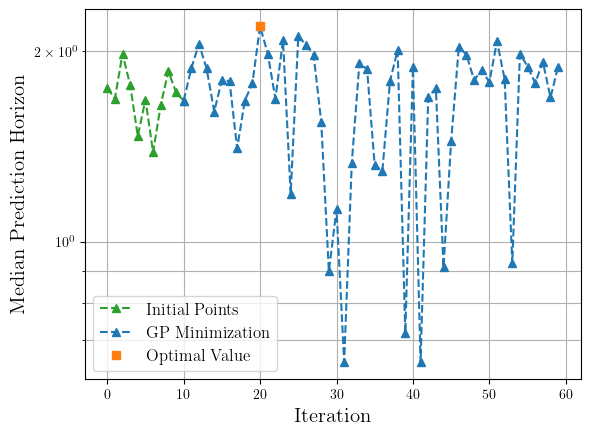

In [39]:
a = n_initial_points
# sorted_idx = np.argsort(x_iters[a:, 0])

xplot = np.arange(func_iters.shape[0])

if a > 0:
    plt.semilogy(
        -func_iters[0:a+1],
        linestyle='--',
        color='C2',
        marker='^',
        label='Initial Points',
    )
    xplot = np.arange(a, func_iters.shape[0])
plt.semilogy(
    xplot,
    -func_iters[a:],
    linestyle='--',
    marker='^',
    label='GP Minimization',#'__nolegend__',
)
plt.semilogy([optim_idx], [-func_iters[optim_idx]], 's', label='Optimal Value')

plt.xlabel('Iteration', fontsize=15)
plt.ylabel('Median Prediction Horizon', fontsize=15)
plt.grid(True, which='major', axis='x')
plt.grid(True, which='both', axis='y')
plt.legend(fontsize=12)

plt.savefig(dir_name_rnn_plots+'/median_PH.pdf', bbox_inches='tight', dpi=300)
plt.show()

<AxesSubplot:title={'center':'Convergence plot'}, xlabel='Number of calls $n$', ylabel='$\\min f(x)$ after $n$ calls'>

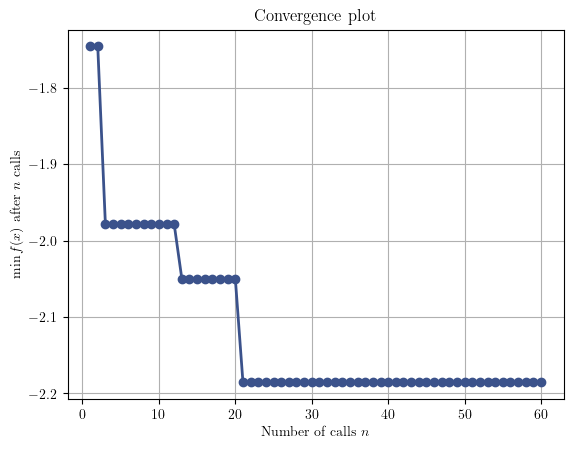

In [40]:
from skopt.plots import plot_convergence
plot_convergence(res)

In [41]:
optimized_vals_dict = {
    'x_iters':x_iters,
    'func_iters':func_iters,
    'optim_x':optim_x,
    'optim_idx':optim_idx,
    'optim_fun':func_iters[optim_idx]
}

with open(dir_name_rnn+'/optimized_vals.txt', 'w') as f:
    f.write(str(optimized_vals_dict))
    
np.savez(
    dir_name_rnn+'/optimized_vals',
    x_iters=x_iters,
    func_iters=func_iters,
    optim_x=optim_x,
    optim_idx=optim_idx,
    optim_fun=func_iters[optim_idx]
)

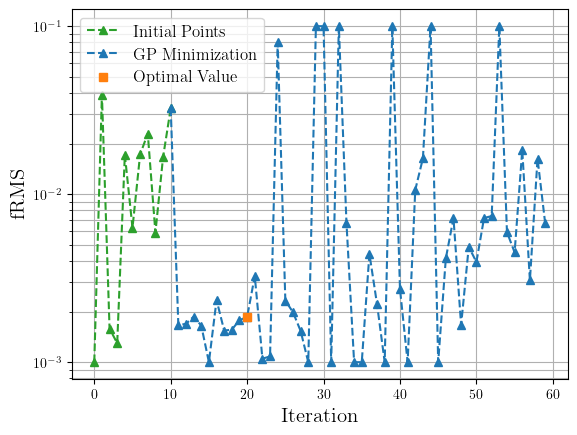

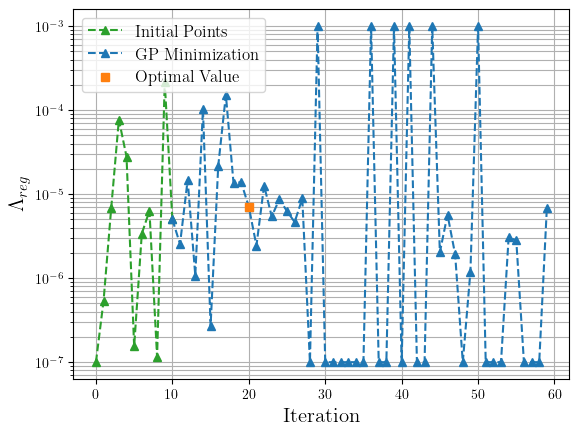

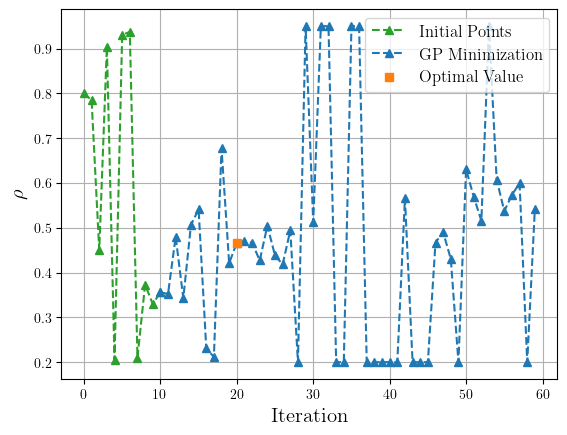

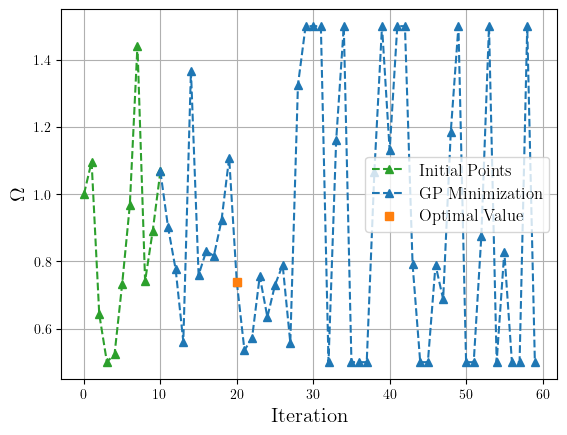

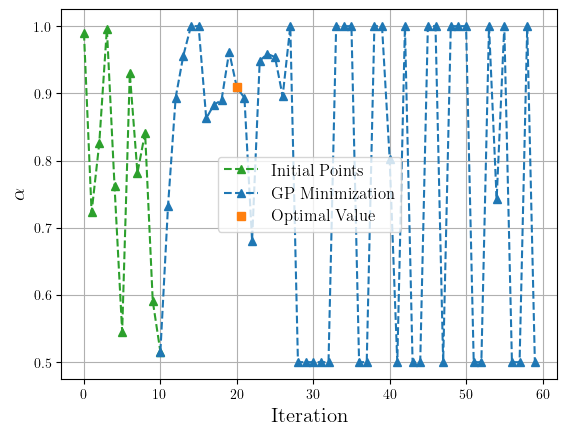

In [42]:
xoptim_names = [
    [r'fRMS', 'fRMS', plt.semilogy],
    [r'$\Lambda_{reg}$', 'lambda_reg', plt.semilogy],
    [r'$\rho$', 'rho', plt.plot],
    [r'$\Omega$', 'omega', plt.plot],
    [r'$\alpha$', 'alpha', plt.plot],
    # [r'Degree of Connectivity', 'deg_of_connectivity', plt.plot],
]
if vary_deg_connect == True:
    xoptim_names.append([r'Degree of Connectivity', 'deg_of_connectivity', plt.plot])

for i in range(len(xoptim_names)):
    a = n_initial_points
    # sorted_idx = np.argsort(x_iters[a:, 0])

    xplot = np.arange(x_iters.shape[0])
    if a > 0:
        xoptim_names[i][2](
            x_iters[:, i][0:a+1],
            linestyle='--',
            color='C2',
            marker='^',
            label='Initial Points',
        )
        xplot = np.arange(a, x_iters.shape[0])
    xoptim_names[i][2](
        xplot,
        x_iters[:, i][a:],
        linestyle='--',
        marker='^',
        label='GP Minimization',#'__nolegend__',
    )
    xoptim_names[i][2]([optim_idx], [x_iters[optim_idx, i]], 's', label='Optimal Value')

    plt.xlabel('Iteration', fontsize=15)
    plt.ylabel(xoptim_names[i][0], fontsize=15)
    plt.grid(True, which='major', axis='x')
    plt.grid(True, which='both', axis='y')
    plt.legend(fontsize=12)

    plt.savefig(dir_name_rnn_plots+'/'+xoptim_names[i][1]+'.pdf', bbox_inches='tight', dpi=300)
    plt.show()

In [43]:
dir_list = os.listdir(dir_name_rnn+'/tested_ESN')
# dir_list

In [44]:
ph_mean_lst = []
for dir_name in dir_list:
    with np.load(dir_name_rnn+'/tested_ESN/'+dir_name+'/prediction_horizons-testingdata.npz') as f:
        ph_mean = np.mean(f['prediction_horizon_arr'])
        ph_mean_lst.append(ph_mean)
ph_mean_lst = np.array(ph_mean_lst)

In [45]:
idx = np.where(ph_mean_lst == ph_mean_lst.max())[0]

In [46]:
idx, dir_list[idx[0]]

(array([7]), 'test_ESN_027')

In [47]:
# convergence plot
convergence_f = np.empty_like(func_iters)
min_val = np.inf
for i in range(func_iters.shape[0]):
    if func_iters[i] < min_val:
        min_val = func_iters[i]
    convergence_f[i] = min_val

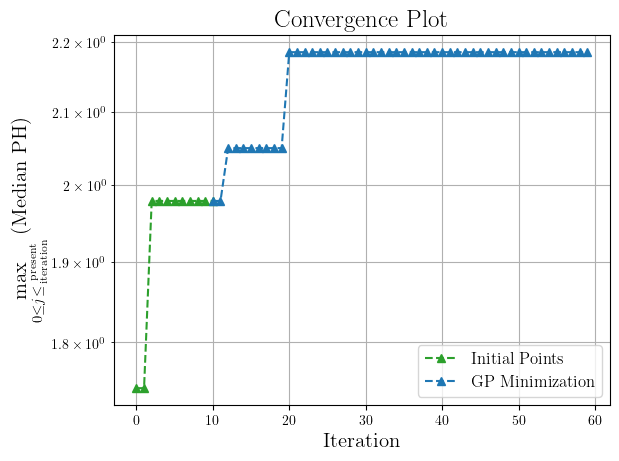

In [48]:
a = n_initial_points
# sorted_idx = np.argsort(x_iters[a:, 0])

xplot = np.arange(x_iters.shape[0])

if a > 0:
    plt.semilogy(
        -convergence_f[0:a+1],
        linestyle='--',
        color='C2',
        marker='^',
        label='Initial Points',
    )
    xplot = np.arange(a, x_iters.shape[0])
plt.semilogy(
    xplot,
    -convergence_f[a:],
    linestyle='--',
    marker='^',
    label='GP Minimization',#'__nolegend__',
)
# plt.semilogy([optim_idx], [func_iters[optim_idx, 0]], 's', label='Optimal Value')

plt.xlabel('Iteration', fontsize=15)
plt.ylabel(
#     r"$$\min_{0 \leq j \leq \mathrm{present \ iteration}} \left( \mathrm{Test \ MSE} \right)$$",
#     r"$$\min_{0 \leq j \leq \mathrm{present \atop iteration}} \left( \mathrm{Test \ MSE} \right)$$",
    r"$$\max_{0 \leq j \leq \mathrm{present \atop iteration}} \left( \mathrm{Median \ PH} \right)$$",
    fontsize=15,
)
plt.title('Convergence Plot', fontsize=18)
plt.grid(True, which='major', axis='x')
plt.grid(True, which='both', axis='y')
plt.legend(fontsize=12)

plt.savefig(dir_name_rnn_plots+'/convergence_plot.pdf', bbox_inches='tight', dpi=300)
plt.show()

### Prediction horizon computation